In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import date, datetime, time, timedelta
from scipy import stats 

sns.set()
%matplotlib inline

'''$$$$$$$$$$$$$$$$$$$$ Start EDA $$$$$$$$$$$$$$$$$$$$'''
def general_explore_file(filepath, show = False):
    df = pd.read_csv(filepath)
    if show:
        explore_df(df)
    return df

def get_prep_data(filepath, parse_dt = ['Opened', 'Closed'], fix_index = 'CaseID'):
    df = pd.read_csv(filepath, parse_dates =parse_dt, infer_datetime_format=True)
    if fix_index:
        df.set_index(fix_index, inplace = True)
    return df
    
def read_csv_chunks_into_df(file_path, chunk_size, parse_date=False):    
    if parse_date:
        chunks = pd.read_csv(file_path, parse_dates= ['Opened','Closed','Updated'], \
                             infer_datetime_format=True, chunksize = chunk_size )
    else:
        chunks = pd.read_csv(file_path, chunksize = chunk_size )
    df = pd.concat(chunks) 
    return df

def explore_df(df):
    print '*********** Shape of df **************'
    print df.shape
    features = df.columns.values    
    print '********** Number of features ***************'
    print len(features) 
    print '********** Features ***************'
    print features
    print '******* Head of df ******************'
    print df.head()
    print '******* Info of df ******************'
    print df.info()
    print '******** Description of df *****************'
    print df.describe()
    return

def import_data(folder, filename):
    '''import the data and set the right datetime '''
    folder = folder
    filename_original = filename
    filepath = folder + filename_original
    df = general_explore_file(filepath)

    df = df.sort_values('CaseID')
    df.set_index('CaseID', inplace = True)

    ''' parse dates'''
    dt_list = ['Opened','Closed','Updated'] # list of datetime columns
    time_format = '%m/%d/%Y %I:%M:%S %p'
    dft = parsedate(df, dt_list, time_format) # parse ['Opened','Closed','Updated'] to timedate 
    return dft
    
def get_unique(df):
    features = df.columns.values
    print '********* Number of unique values **********'
    for feature in features:
        print feature,' ', len(df[feature].unique())
    return 

def get_missing(df):
    print '********* Number of missing values **********'
    df2 = df.isnull()
    features = df.columns.values
    for feature in features:
        temp = df[df2[feature]]
        print feature,' ', len(temp)

def drop_na_row(df,feature):
    df = df.ix[df[feature].notnull(), :]
    return df

def get_value_counts(df, feature_list):
    for feature in feature_list:
        print '************ '+feature+' value counts ***********'
        print df[feature].value_counts(dropna = False)
    return

def parsedate(df, columns, time_format):
    for column in columns:
        df[column] = pd.to_datetime(df[column], format = time_format)
    return df

def days_to_minutes(dt):
    return  dt.total_seconds()//60#(td.seconds//60)%60

def days_to_hours(dt):
    hours = dt.total_seconds()/3600#(td.seconds//60)%60
    return np.round(hours,1)

def get_sorted_category_value(df, category):
    ''' returns sorted categorical values based on the mean process_hours '''
    df1 = df.copy()
    dfm = df1.groupby(category).mean()
    dfm = dfm.sort_values('Process_hours')
    return dfm.index

def category_to_numer_dict(df, category, values):
    '''
    Change a categorical column to numeric and save the categorical values in a 
    dictionary for later reference values is sorted list of categorical values
    '''
    dict = defaultdict(str)
    for i,value in enumerate(values):
        dict[i] = value # store the categorical values in a dictionary for reference
        df.ix[df[category]==value, category] = i
    df[category].astype(int, inplace=True)
    return dict

def category_to_numer_basic(df, category):
    '''Change a categorical column to numeric and save the categorical 
    values in a dictionary for later reference (basic version)'''
    values = df[category].unique()
    for i,value in enumerator(values):
        df.ix[df[category]==value, category] = i
    df[category].astype(int, inplace=True)
    return df

def batch_process_categories(df, categories):
    '''convert categorical features to numerical by batch, 
    return a dictionary of dictionaries storing the mapping of categorical value to number'''
    cate_dict = {}
    for category in categories:
        '''Convert the categoricl column to numerical'''
        if  category in df.columns.values:
            cate_val = get_sorted_category_value(df,category) 
            '''The category_to_numer_dict() modify the input dataframe by side-effect and return a dictionary'''
            cate_dict[category] = category_to_numer_dict(df, category, cate_val)
    return cate_dict

def check_group_mean(df, groupby_cols, target_cols):
    for col in groupby_cols:
        dfm = df.groupby(col).mean()
        print dfm[target_cols]
    return

def check_group_stats(df, groupby_cols, target_cols):
    for col in groupby_cols:
        dfm = df.groupby(col).describe()
        print dfm[target_cols]
    return
'''$$$$$$$$$$$$$$$$$$$$ Finishing EDA $$$$$$$$$$$$$$$$$$$$'''

'''$$$$$$$$$$$$$$$$$$$$ End importing data $$$$$$$$$$$$$$$$$$$$'''
def clean_data(dft):
    '''remove and save the cases that are not closed'''
    dft_still_open = dft[dft['Closed'].isnull()] # cases that not closed
    filename_open = 'SF311_still_open_raw.csv'
    dft_still_open_csv_path = folder + filename_open
    dft_still_open.to_csv(dft_still_open_csv_path) # dft_still_open.csv contains cases that not closed

    '''calculate the process time '''
    condition = dft['Closed'].notnull()
    dft_closed = dft[condition] # cases that are closed 
    dft_closed['Process_days'] = dft_closed['Closed'] - dft_closed['Opened']
    dft_closed['Process_hours'] = dft_closed['Process_days'].apply(days_to_hours)

    ''' remove cases with process time <= 0 hours and save theses cases '''
    dft_wrong_dates = dft_closed[dft_closed['Process_hours'] <= 0]
    filename_wrong_dates = 'SF311_wrong_dates_raw.csv'
    dft_wrong_dates_csv_path = folder + filename_wrong_dates
    dft_wrong_dates.to_csv(dft_wrong_dates_csv_path) 
    # dft_wrong_dates_raw.csv contains cases that have wrong dates: closed before opened'''re
    dft_right_dates = dft_closed[dft_closed['Process_hours'] > 0]

    ''' remove duplicated cases and save theses cases '''
    dft_duplicates, dft_valid = check_word_in_col(dft_right_dates, 'Status Notes', 'Duplicate')
    filename_duplicates = 'SF311_duplicates_raw.csv'
    dft_duplicates_csv_path = folder + filename_duplicates
    dft_duplicates.to_csv(dft_duplicates_csv_path) # dft_duplicates_raw.csv contains cases that are duplicated
    
    '''convert Process_days to float'''
    dft_valid['Process_days'] = dft_valid['Process_hours']/24.0
    
    '''save raw valid cases'''
    filename_valid = 'SF311_valid_raw.csv'
    dft_valid_csv_path = folder + filename_valid
    dft_valid.to_csv(dft_valid_csv_path)
    
    '''remove unnecessary columns and save the cases to csv file'''
    drop_col = ['Updated','Status', 'Media URL']
    dft_valid_reduced = dft_valid.drop(drop_col, axis =1)
    filename_reduced = 'SF311_valid_reduced.csv'
    dft_valid_reduced_csv_path = folder + filename_reduced
    dft_valid_reduced.to_csv(dft_valid_reduced_csv_path)
    
    print 'Number of original cases: ', len(dft)
    print 'Cases that are not closed: ', len(dft_still_open)
    print 'Cases with process time <= 0: ', len(dft_wrong_dates)
    print 'Cases with process time > 0: ', len(dft_right_dates)
    print 'Duplicated cases: ', len(dft_duplicates)
    print 'Valid cases: ', len(dft_valid)
    return dft_valid_reduced


def plot_data_on_date(df, data_col, year = False, month = False, day = False, dot = True):
    ''' set index to date and plot df column data against the index, year can be Boolean or int'''
    dfcp = df.copy()
    dfcp.set_index('Opened', inplace = True)
    if (type(year)==int) & (type(month)==int) & (type(day)==int):
        cond1 = dfcp.index.year == year
        cond2 = dfcp.index.month == month
        cond3 = dfcp.index.day == day
        dfcp1 = dfcp[cond1 & cond2 & cond3]           
    elif (type(year)==int) & (type(month)==int):
        cond1 = dfcp.index.year == year
        cond2 = dfcp.index.month == month
        dfcp1 = dfcp[cond1 & cond2]        
    elif type(year)==int:
        dfcp1 = dfcp[dfcp.index.year == year]
    else:
        dfcp1 = dfcp
    if dot:     
        dfcp1[data_col].plot(figsize=(18,16), c='m', alpha = 0.2,style='o')
    else:
        dfcp1[data_col].plot(figsize=(18,16), c='k', alpha = 0.2)
    plt.show()
    return

'''This function is not necessary, becasue plot_data_on_date() can do scatter plot'''
'''plot a scatter plot on data'''
def scatter_data_on_date(df, data_col, year = False, month = False, day = False):
    ''' set index to date and plot df column data against the index; year, month, and day can be Boolean or int'''
    dfcp = df.copy()
    dfcp['Opened_Int'] = dfcp['Opened'].astype(np.int64)
    dfcp.set_index('Opened', inplace = True)
    if (type(year)==int) & (type(month)==int) & (type(day)==int):
        cond1 = dfcp.index.year == year
        cond2 = dfcp.index.month == month
        cond3 = dfcp.index.day == day
        dfcp1 = dfcp[cond1 & cond2 & cond3]                   
    elif (type(year)==int) & (type(month)==int):
        cond1 = dfcp.index.year == year
        cond2 = dfcp.index.month == month
        dfcp1 = dfcp[cond1 & cond2]        
    elif type(year)==int:
        dfcp1 = dfcp[dfcp.index.year == year]        
    else:
        dfcp1 = dfcp
    dfcp1.plot(kind = 'scatter', x='Opened_Int', y='Process_days', alpha = 0.2, c = 'm', figsize=(20,10))  
    return


'''######## this can be a short lambda expression########'''
def get_str_list(string):
    '''convert to a list of string'''
    return str(string).split()

'''######## this can be a short lambda expression########'''
def check_dup(str_list):
    '''check if word 'Duplicate' is in the string list'''
    return 'Duplicate' in str_list

def check_word_in_col(df, column, word):
    '''check if a word in the column, returns a tuple of dataframes, 
    the first one contains the word and second one does not''' 
    df1 = df.copy()
    get_str_list = lambda x: str(x).split()
    check_dup = lambda x: word in x

    df1[column+'1'] = df1[column].apply(get_str_list) # turn df1[column] into a list of strings
    cond = df1[column+'1'].apply(check_dup) # check if df1[column+'1'] contains the word
    df_found = df[cond]
    df_not_found = df[~cond]
    return df_found, df_not_found

def add_features(df):
    df1 = df.copy()
    '''Add features: Day of week, Month, Year, Weekend '''
    df1['Day_Of_Week'] = df1['Opened'].dt.dayofweek
    df1['Month'] = df1['Opened'].dt.month
    df1['Year'] = df1['Opened'].dt.year
    
    df1['Weekend'] = (df1['Day_Of_Week'].isin((5,6))).astype(int) # if the open day is at weekend
    '''Add feature Holiday and Before_Holiday'''
    df1['Opened_Int'] = df1['Opened'].astype(np.int64)
    
    cal = calendar()
    holidays = cal.holidays()
    df1['Holiday'] = ((df1['Opened'].dt.date).astype('datetime64').isin(holidays)).astype(int)
    df1['Before_Holiday'] = (((df1['Opened'].dt.date).astype('datetime64')+timedelta(days = 1))\
                             .isin(holidays)).astype(int)
    num_of_holiday = len(df1[df1['Holiday'] == 1])
    num_of_before_holiday = len(df1[df1['Before_Holiday'] == 1])
    return df1

def get_oneway_anova(df, target_col, group_col, group_list=False):
    if group_list:
        groups = group_list
    else:
        groups = list(df[group_col].unique())
    datasets =[]
    for component in groups:
        df_temp = df[df[group_col] == component]
        datasets.append(np.array(df_temp[target_col]))
    f_val, p_val = stats.f_oneway(*datasets)  
    print "One-way ANOVA P =", p_val  
    return p_val

def add_current_open(df):
    '''add column Current_Open which has the number of current open cases'''
    def get_open_cases(opt):
        condition1 = df['Opened'] < opt
        condition2 = df['Closed'] > opt
        open_cases = df[condition1 & condition2]
        return len(open_cases)
    df['Current_Open'] = df['Opened'].apply(get_open_cases)
    return df

def create_pilot(df, folder, filename):    
    '''Create a pilot dataset of most recent 100000 cases for preliminary 
    modeling and feature engineering, save as SF311_pilot.csv '''
    pilot = df.iloc[:100000,:]
    pilot.to_csv(folder+filename_pilot)
    return

def impute_neighbor_knn():
    pass

def creat_data_chunk(df, folder, filename, days = 730):
    if timedelta(days = days) > df['Opened'].max()-df['Opened'].min():
        print 'Error! Days over the limit!'
        return
    new_end_date = df['Opened'].max() - timedelta(days = days) # get the date that is 2 year before the data collecting date
    condition1 = df['Opened'] <= new_end_date
    condition2 = df['Process_days'] <= days
    df_chunk = df[condition1 & condition2]
    df_chunk.to_csv(folder+filename)
    return

Data cleaning procedure:

1. Read data from SF311.csv (2092917 cases).

1.1. Parse dates of 'Opened', Closed','Updated' to pd.datetime64.

1.2. Sort the data by CaseID in asceding order, which is the same order by case open time.

1.3. Remove 99549 open cases (with no closed time/status==open), these cases are stored in SF311_still_open_raw.csv.

2. There are 1993368 cases left that are closed.

2.1. Calculate the 'Process_days', a time_delta object, by ('Closed' - 'Opened').

2.2. Creat 'Process_hours' (data type is float) by converting 'Process_days' to hours.

2.3. Remove the cases with process hours <= 0hr(23575 cases). These cases are stored in SF311_wrong_dates_raw.csv. There are The rest valide 1969793 cases left.

2.4. Remove the duplicated cases (34773 cases). These cases are stored in SF311_duplictates_raw.csv.

2.4. The rest valide 1935020 cases were stored in SF311_valid_raw.csv

3. For the 1935020 valid cases conitue data cleaning process.

3.1. Remove columns: 'Updated','Status', 'Media URL', becuase these columns offer no helpful information. 'Upated' is basically the time for closed or some time between open and closed, which does not offer any useful information. 'Status' is redundent because only closed cases are used in the project. 'Media URL' has too many missing values 1712026 cases.

3.2. Convert 'Process_days' a time-delta object to float. Save these cases to SF311_valid_reduced.csv.

4. Feature engineering (add new features). (Use a pilot subset of data, 100,000 for feature engineering and modeling)

4.1. Add column Day_Of_Week, indicating the day of the week: 0 to 6 for Monday to Sunday, respectively.

4.2. Add column Month, indicating the which month: 0 to 6 for Monday to Sunday, respectively.

4.3. Add column Year, 2008 to 2016.

4.4. Add column Weekend, indicating if the case is opened on weekend: 1 for True and 0 for False

4.5. Add column Holiday, indicating if the case is opened on federal holiday: 1 for True and 0 for False (41063 cases).

4.6. Add column Before_Holiday, indicating if the case is opened one day before federal holiday: 1 for True and 0 for False (41095 cases). The dataset has 19 columns.

4.7. Add column Opened_Int which casts the Opened datetime object to int

4.8. Save dataset to csv file as SF311_engineered.csv

4.9. Plot the Process days over time and find the linearly decreasing trend of maximum job length over the time span. There are two potential factors contributing to this observation. 1) The maximum job length appearently decreases because long jobs last long and for the later opened cases they may not be closed at the time of inspection. When I exclude the still open cases, some of those possible long jobs are excluded, making the maximum job length shorter for those more recent cases. 2) The city has improved the cival service. To determine if the second factor is a contributor, I need to look at a truncated dataset. The strategy is to investigate the cases with maximum job length of 2 years from 2008 July upto 2015 March (2 years earlier from the current data collecting point) of tatal 1175726 cases. In this way, all cases in this interval will have chance to be finished. Dataset is stored in csv file SF311_chunk.csv.

Still see strong trend of decreasing mean job length in the truncated dataset, suggesting that the reduction of the job length (within the job that length < 2 years) is significant not an artifact created by sampling. The variable year can cetainly explain part of this trend, so it can be used in a random forest model. Another option is to create a continue time variable nth month (0 to from 2008 July to the data collecting point), or include a continue time variable Opend_int, which is basically transfer the datetime object to an int. All these can be included in the random forest model.

Also need to inspect the histogram of cases that are still open.

Did one-way ANOVA on Process_days on year in the full and truncated dataset. Both datasets yielded p-value of 0.0, indicating the difference among years are significantly different.

4.10. Create a pilot dataset of 100000 cases (from begining) for preliminary modeling and feature engineering, save as SF311_pilot.csv

4.11. Add the column Current_Open, which has the number of current open cases (this process is computational intensive, so try it with the pilot dataset first, not done yet).

In [ ]:
'''
*****************************************************************
From here: can be skipped because the valid cases have been stored in csv file
*****************************************************************
'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_original = 'SF311.csv'
dft = import_data(folder, filename_original)
dft_valid_reduced = clean_data(dft)

In [40]:
''' verify the new csv files'''
filename_open = 'SF311_still_open_raw.csv'
filename_wrong_dates = 'SF311_wrong_dates_raw.csv'
filename_duplicates = 'SF311_duplicates_raw.csv'
filename_valid = 'SF311_valid_raw.csv'
filename_reduced = 'SF311_valid_reduced.csv'
ndf = pd.read_csv(folder+filename_open)
print ndf.shape
wdf = pd.read_csv(folder+filename_wrong_dates)
print wdf.shape
ddf = pd.read_csv(folder+filename_duplicates)
print ddf.shape
vdf = pd.read_csv(folder+filename_valid)
print vdf.shape
rdf = pd.read_csv(folder+filename_reduced)
print rdf.shape

(99549, 16)
(23575, 18)
(34773, 18)


/Users/haowei/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1935020, 18)
(1935020, 15)


In [3]:
'''Read data from new cleaned and reduced csv file'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_reduced = 'SF311_valid_reduced.csv'

cfdf = get_prep_data(folder+filename_reduced)
cfdf_cp = cfdf.copy()
print 'reduced dataframe shape: ', cfdf.shape

cfdf = add_features(cfdf)

reduced dataframe shape:  (1935020, 14)


In [ ]:
# '''Deal with request type using tf-idf then clustering'''
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk import pos_tag
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.metrics.pairwise import linear_kernel
# import re
# #re.split('; |, ',str)

# rt = cfdf['Request Type'].apply(lambda x: str(x).lower().split())
# documents = list(rt)
# print documents[:30]

# # Tokenize and remove stop words

# # 1. Create a set of documents.
# #documents = [' '.join(article['content']).lower() for article in coll.find()]

# # 2. Create a set of tokenized documents.
# #docs = [word_tokenize(content) for content in documents]
# # no need to do tokenize because there is no punctuation
# #print docs[:15]

# # 3. Strip out stop words from each tokenized document.
# stop = set(stopwords.words('english'))
# docs = [[word for word in words if word not in stop] for words in documents]
# print docs[:30]

# # Stemming / Lemmatization

# # 1. Stem using both stemmers and the lemmatizer
# porter = PorterStemmer()
# # snowball = SnowballStemmer('english')
# # wordnet = WordNetLemmatizer()
# docs_porter = [[porter.stem(word) for word in words] for words in docs]
# # docs_snowball = [[snowball.stem(word) for word in words] for words in docs]
# # docs_wordnet = [[wordnet.lemmatize(word) for word in words] for words in docs]
# print docs_porter[:30]

In [24]:
'''
*****************************************************************
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
*****************************************************************
'''
'''Read data from new engineered csv file'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_engineered = 'SF311_engineered.csv'

df = get_prep_data(folder+filename_engineered)
df_cp = df.copy()

# print 'Engineered dataframe info: ', df.info()
# df.head(2)

In [23]:
'''Deal with request type using tf-idf then clustering'''
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import re
#re.split('; |, ',str)

rt = df['Request Type'].apply(lambda x: str(x).lower().split())
documents = list(rt)
print documents[:30]

# Tokenize and remove stop words

# 1. Create a set of documents.
#documents = [' '.join(article['content']).lower() for article in coll.find()]

# 2. Create a set of tokenized documents.
#docs = [word_tokenize(content) for content in documents]
# no need to do tokenize because there is no punctuation
#print docs[:15]

# 3. Strip out stop words from each tokenized document.
stop = set(stopwords.words('english'))
docs = [[word for word in words if word not in stop] for words in documents]
print docs[:30]

# Stemming / Lemmatization

# 1. Stem using both stemmers and the lemmatizer
porter = PorterStemmer()
# snowball = SnowballStemmer('english')
# wordnet = WordNetLemmatizer()
docs_porter = [[porter.stem(word) for word in words] for words in docs]
# docs_snowball = [[snowball.stem(word) for word in words] for words in docs]
# docs_wordnet = [[wordnet.lemmatize(word) for word in words] for words in docs]
print docs_porter[:30]

NameError: name 'df' is not defined

In [ ]:
'''Deal with request type using tf-idf then clustering'''
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from PremodelingProcess import train_vali_split, get_df_for_modeling, dump_object_to_pickle, get_df_for_engineer
import re

'''Check if there is pickle files of dataframe ready for load'''
filename_train_pickle = '../data/SF311_train.pickle'
filename_train = '../data/SF311_train.csv'
df = get_df_for_engineer(filename_train_pickle, filename_train)
print 'dataframe shape: ', df.shape
print df.head()

rt = df['Request Type'].apply(lambda x: str(x).lower())
documents = list(rt)[:1000]
print documents[:10]

# Tokenize and remove stop words

# 1. Create a set of documents.
#documents = [' '.join(article['content']).lower() for article in coll.find()]

# 2. Create a set of tokenized documents. No need to tokenize because there is no punctuation in the phrase
# docs = [word_tokenize(content) for content in documents]
# print docs[:15]

# # 3. Strip out stop words from each tokenized document.
# stop = set(stopwords.words('english'))
# docs = [[word for word in words if word not in stop] for words in docs]

# Stemming / Lemmatization

# 1. Stem using both stemmers and the lemmatizer
# porter = PorterStemmer()

# snowball = SnowballStemmer('english')
# wordnet = WordNetLemmatizer()
# docs_porter = [[porter.stem(word) for word in words] for words in documents]

# docs_snowball = [[snowball.stem(word) for word in words] for words in docs]
# docs_wordnet = [[wordnet.lemmatize(word) for word in words] for words in docs]

#print docs_porter[:30]

# 3. Create word count vector over the whole corpus.
# cv = CountVectorizer(stop_words='english')
# vectorized = cv.fit_transform(documents)

tfidf = TfidfVectorizer(stop_words='english')
tfidfed = tfidf.fit_transform(documents)

print tfidfed
'''save ftidf model to pickle file, will be used to transform the text in test file'''
filename_tfidf_pickle = '../data/SF311_tfidf.pickle'
filename_tfidfed_pickle = '../data/SF311_tfidfed.pickle'
dump_object_to_pickle(tfidf,filename_tfidf_pickle)
dump_object_to_pickle(tfidfed,filename_tfidfed_pickle)

In [3]:
df['Opened_Int'] = df['Opened'].astype(float)
filename_engineered = 'SF311_engineered.csv'
df.to_csv(folder+filename_engineered)



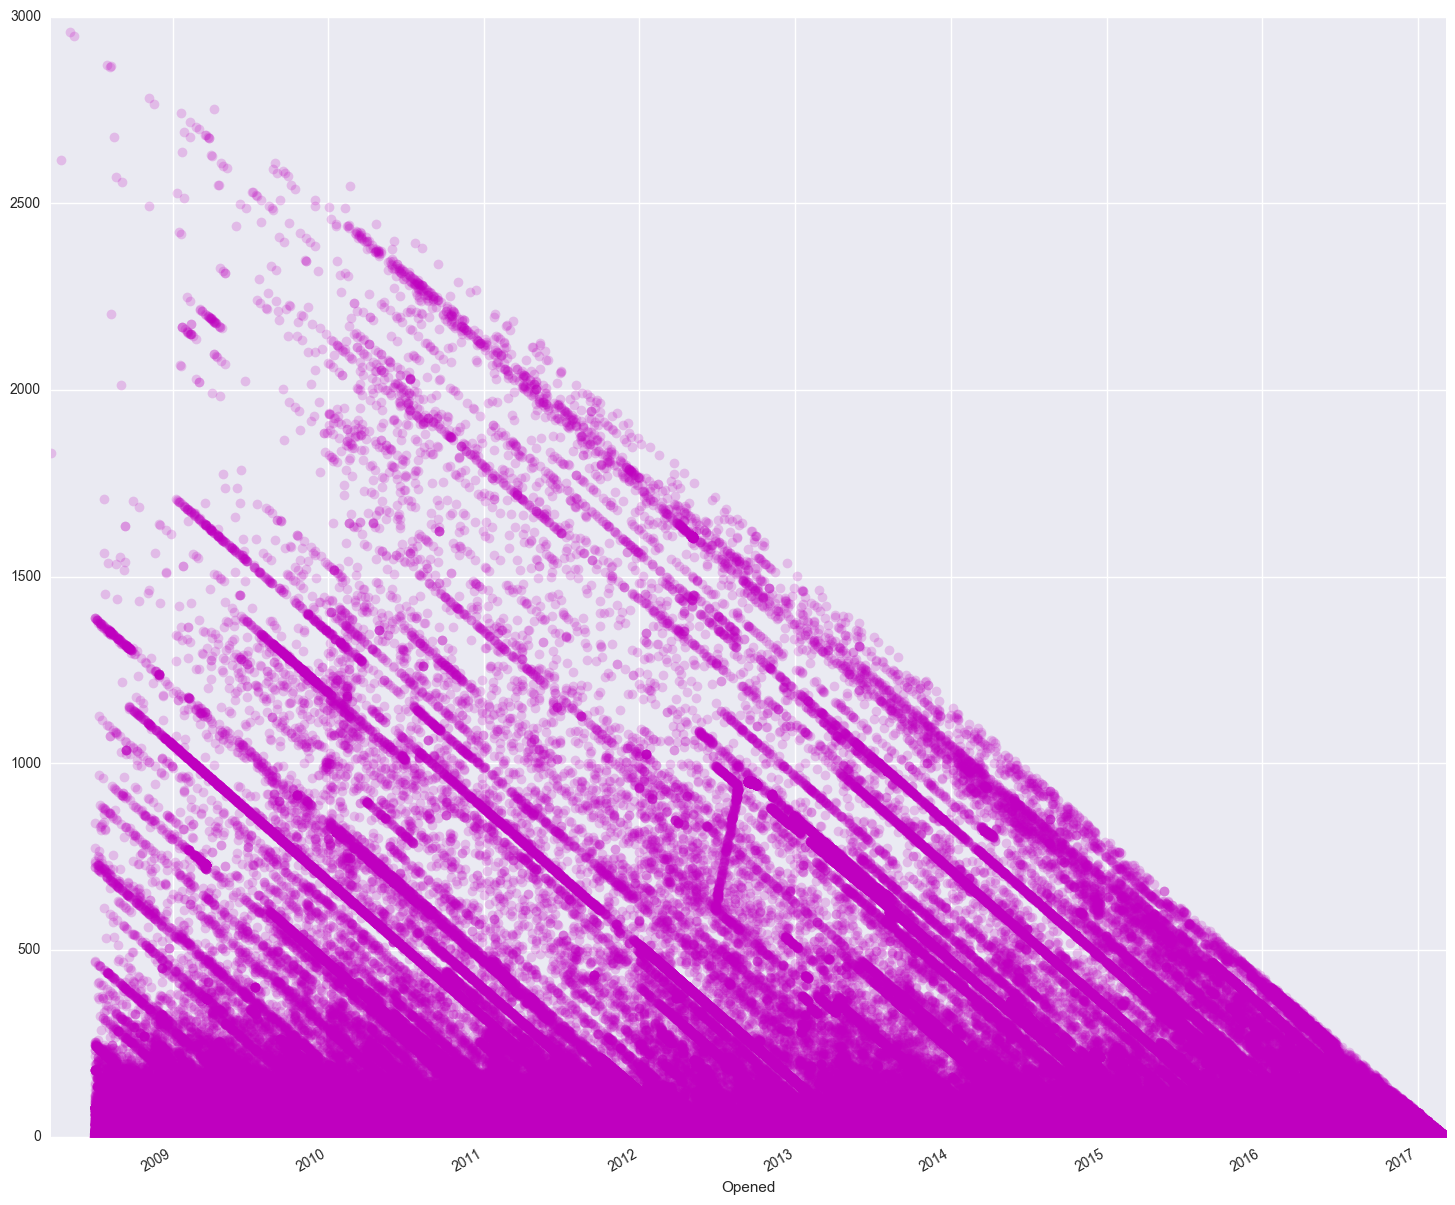

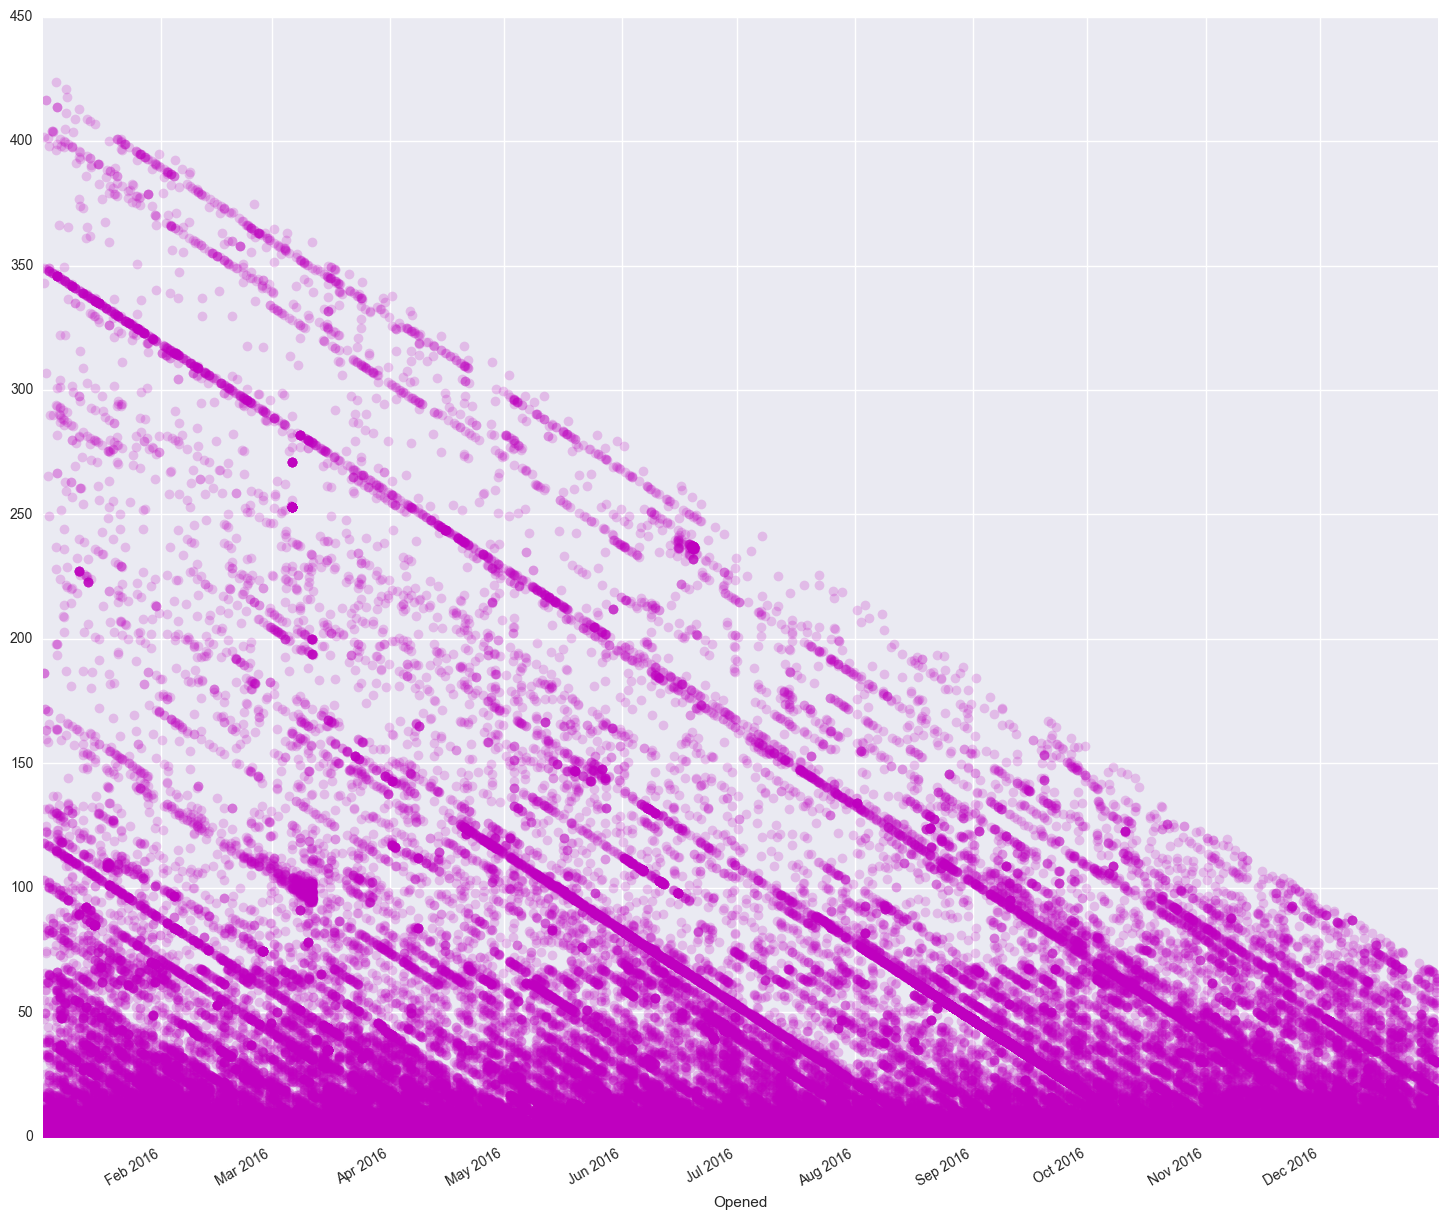

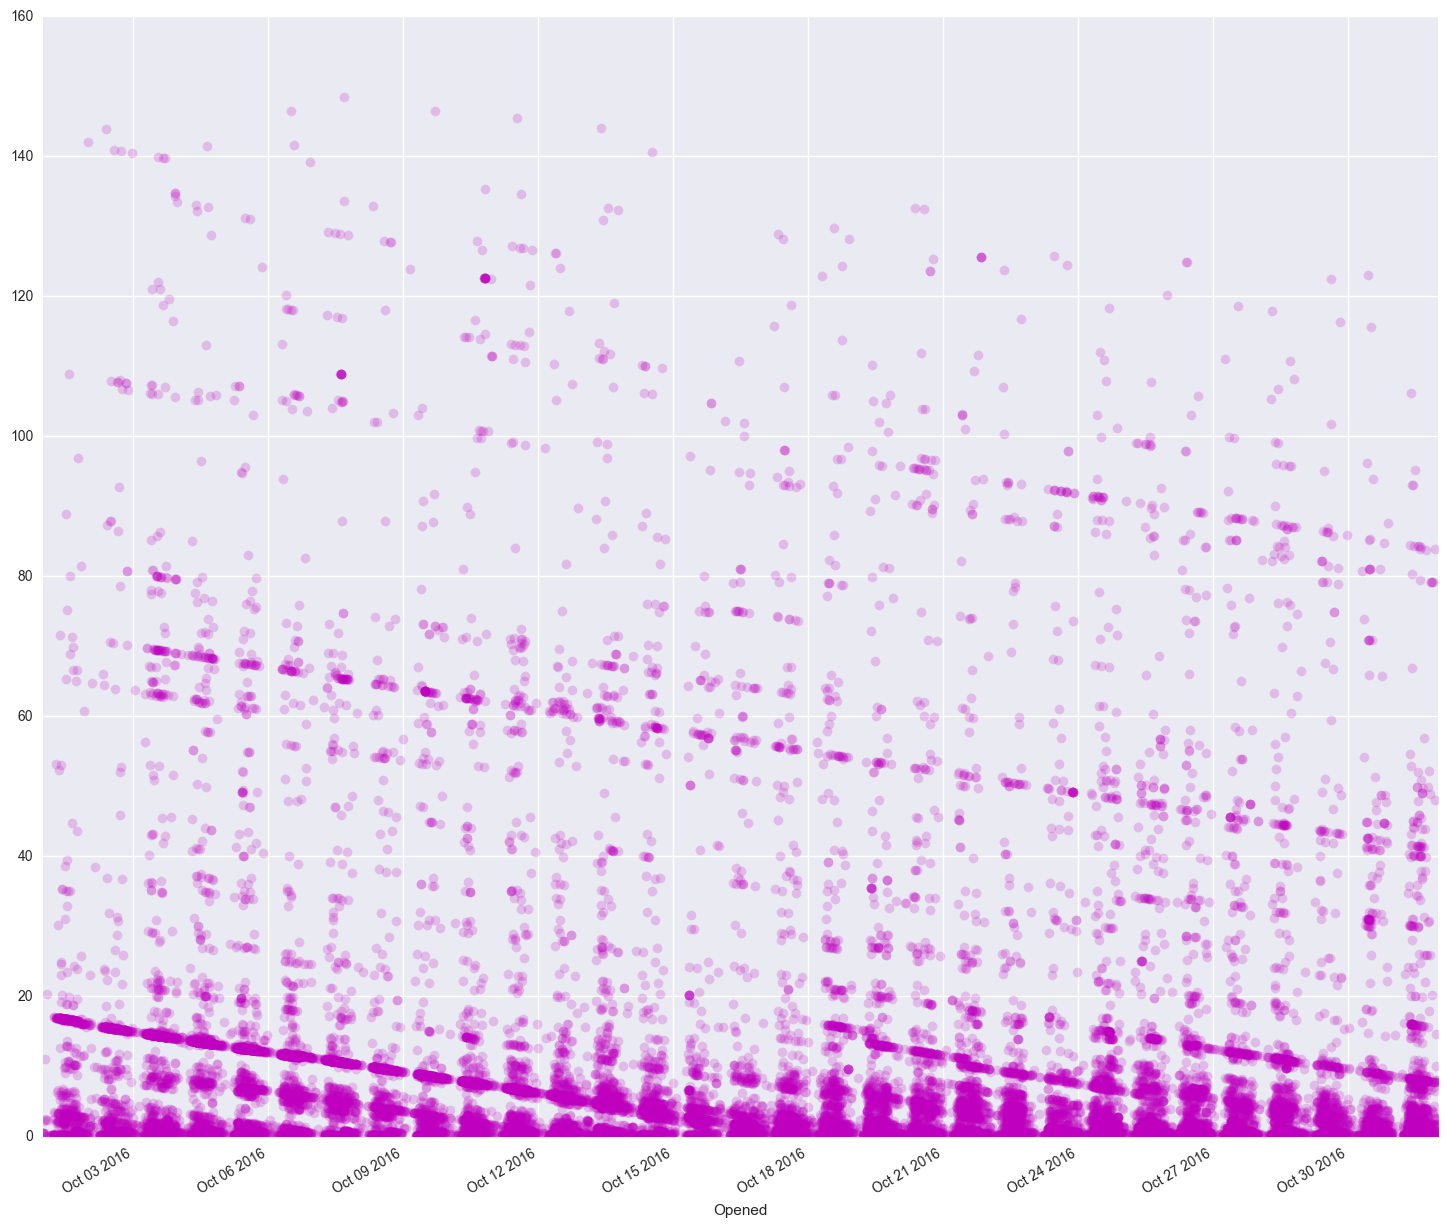

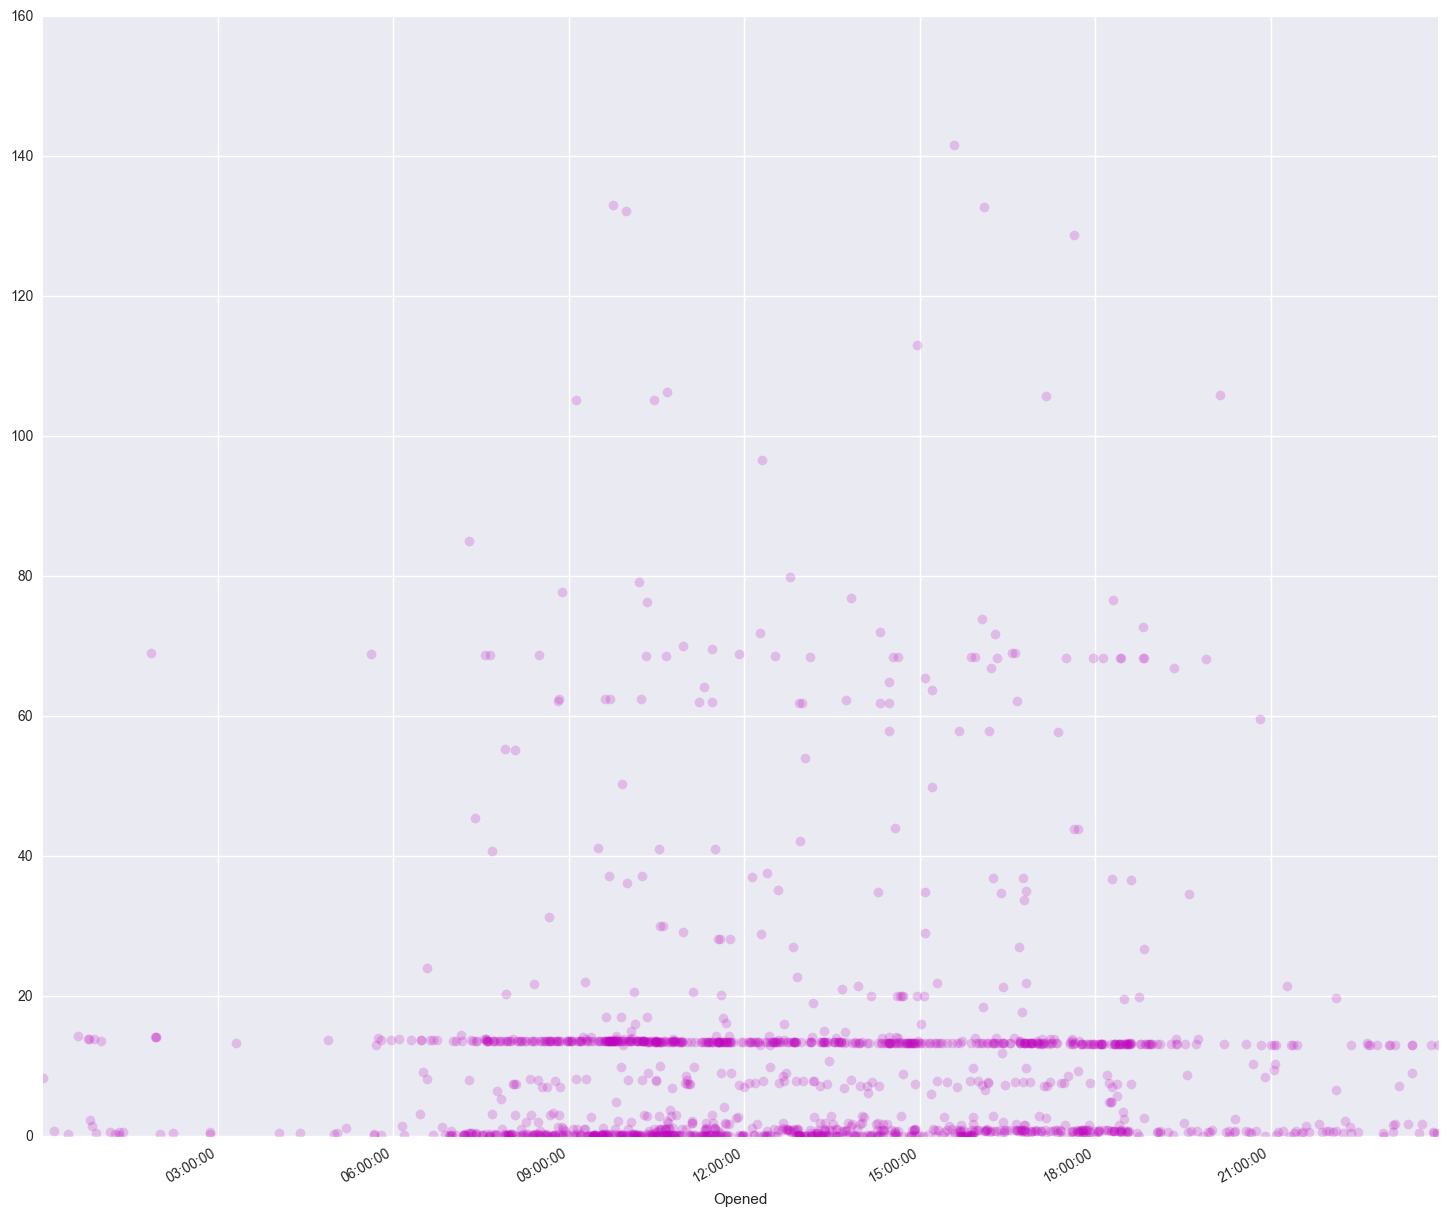

In [33]:
'''plot process days over the time'''
plot_data_on_date(df, 'Process_days')
plot_data_on_date(df, 'Process_days', year = 2016)
plot_data_on_date(df, 'Process_days', year = 2016, month = 10)
plot_data_on_date(df, 'Process_days', year = 2016, month = 10, day = 4)

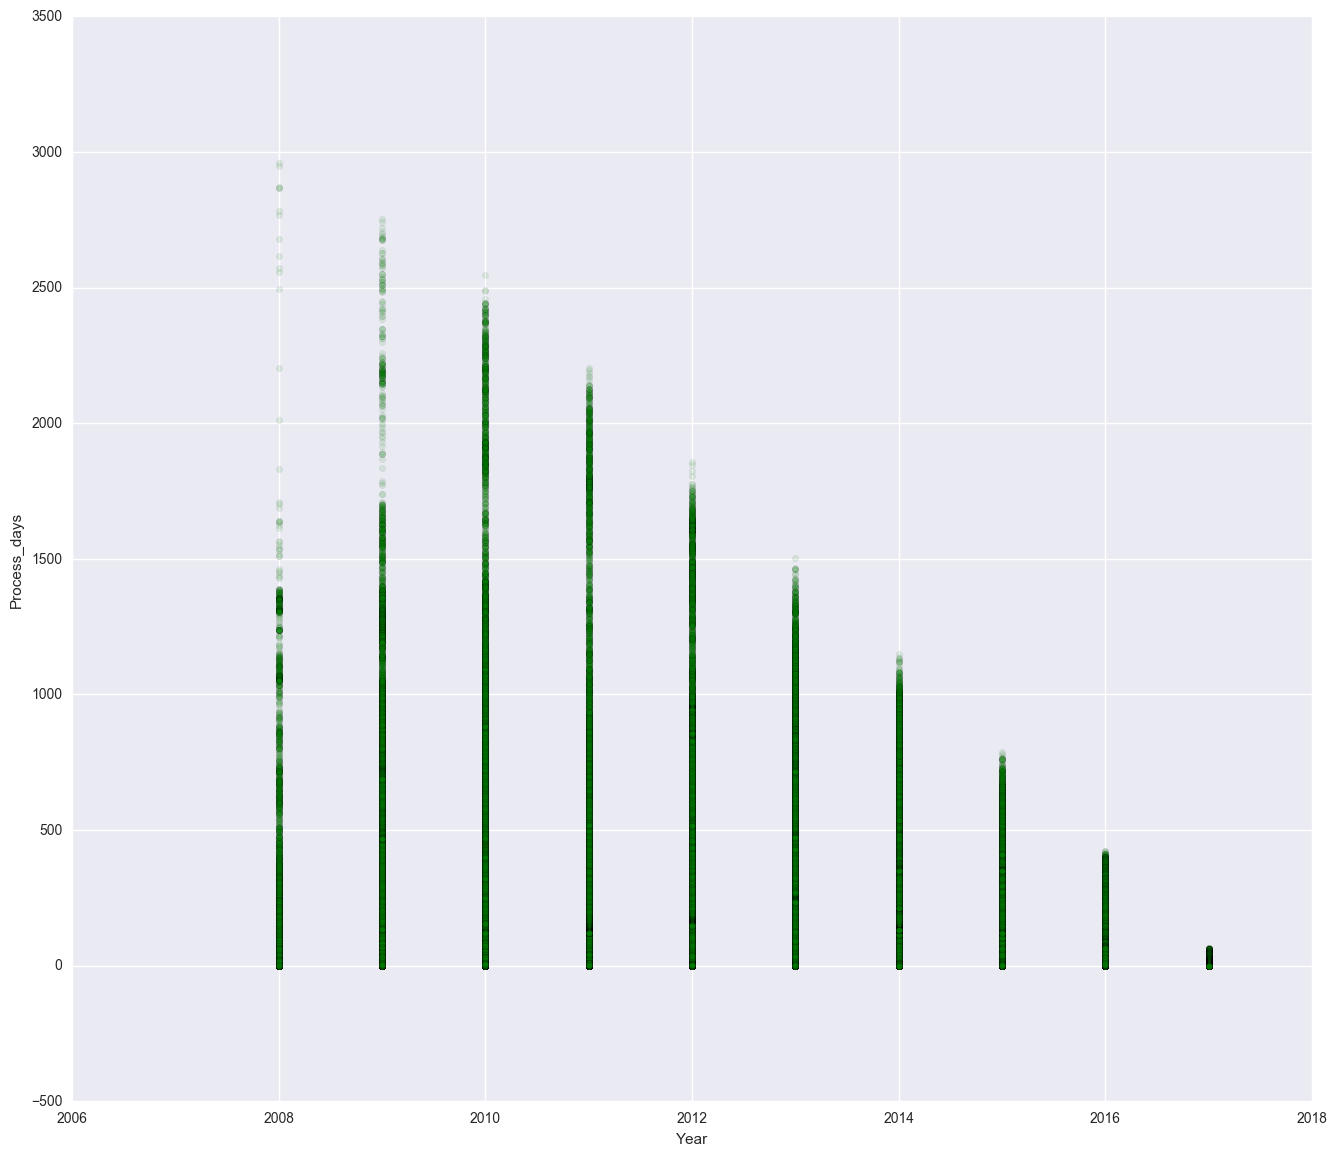

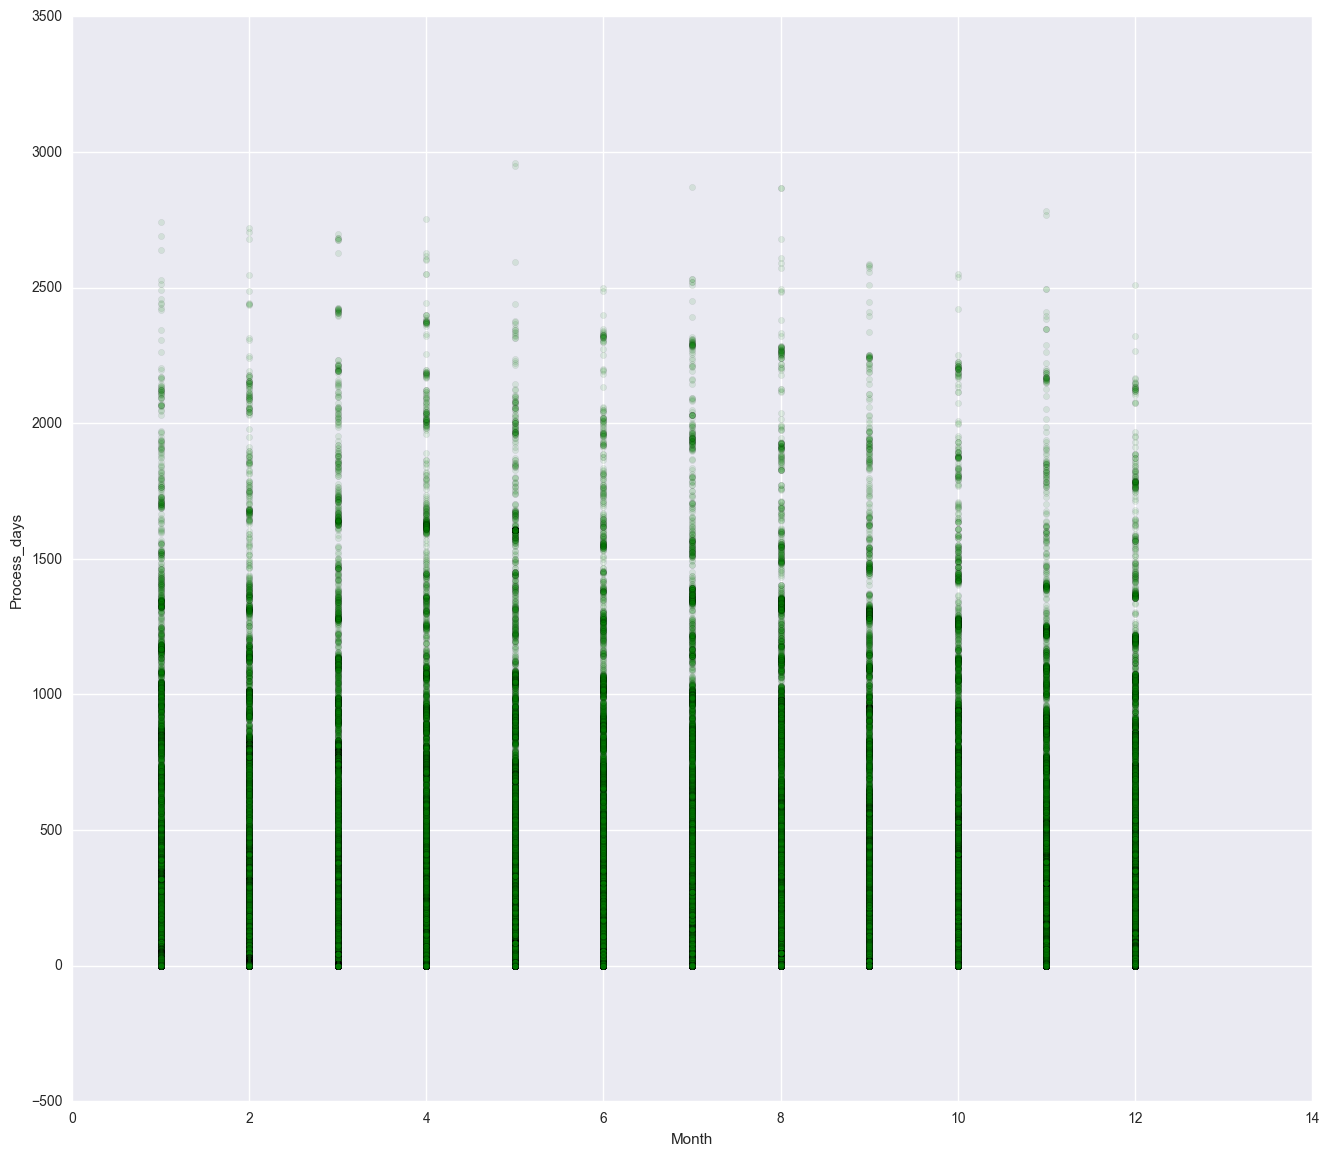

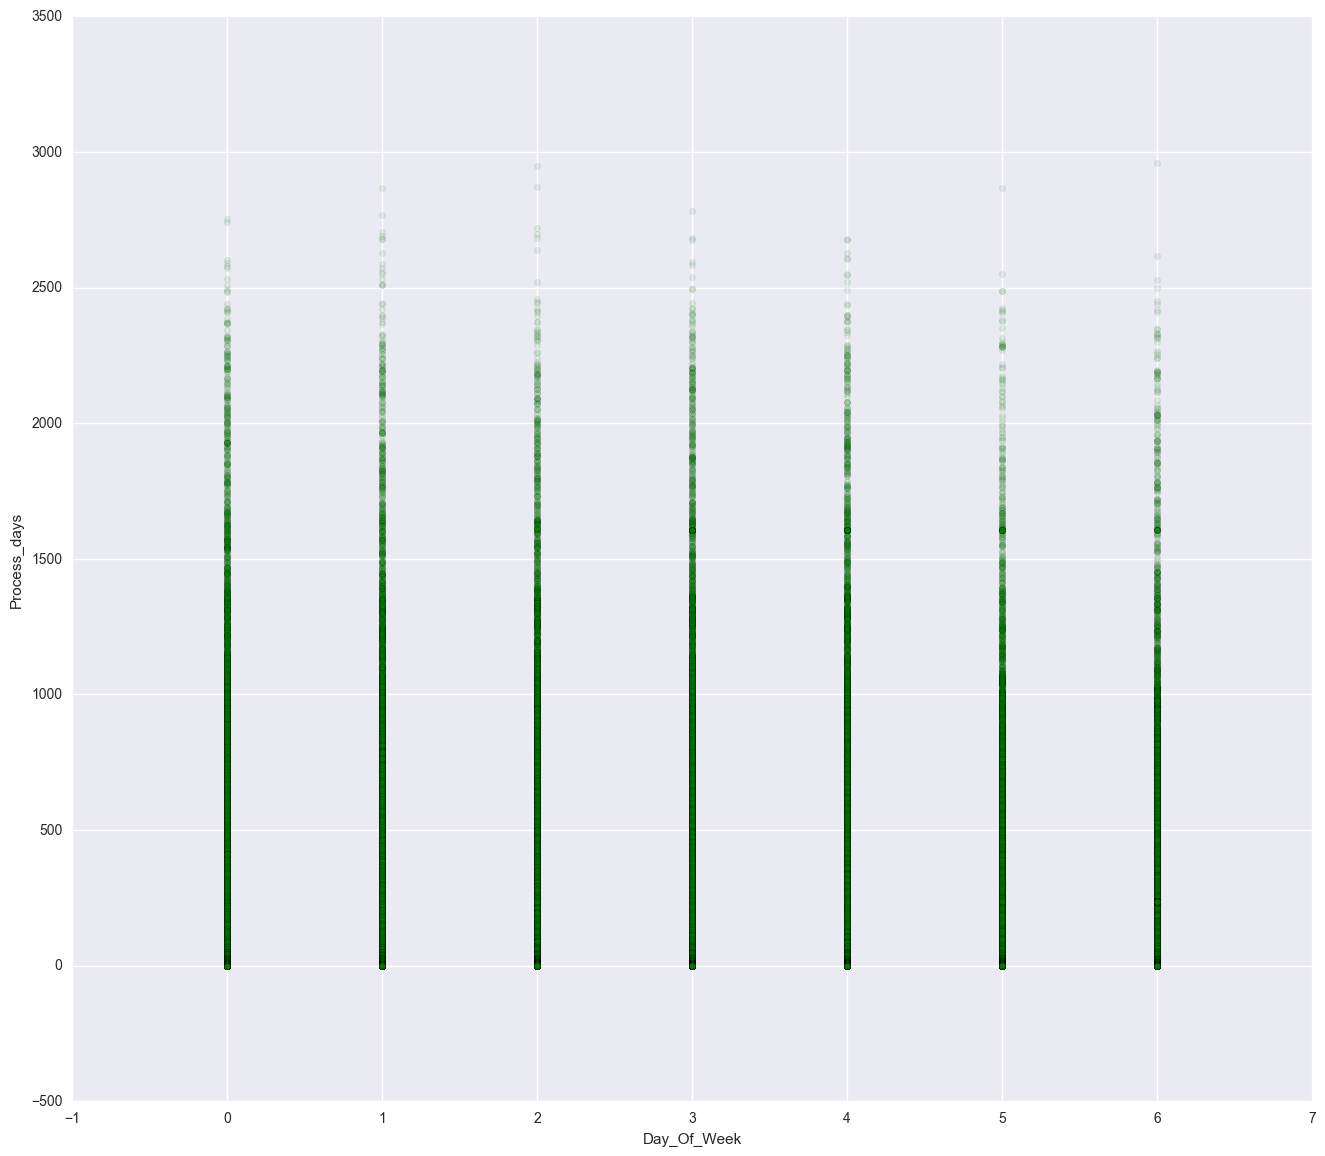

In [63]:
df.plot(kind = 'scatter', x='Year', y='Process_days', c = 'g', alpha = 0.1, figsize = (16,14))
plt.show()
df.plot(kind = 'scatter', x='Month', y='Process_days',c = 'g', alpha = 0.1,figsize = (16,14))
plt.show()
df.plot(kind = 'scatter', x='Day_Of_Week', y='Process_days',c = 'g', alpha = 0.1,figsize = (16,14))
plt.show()

In [ ]:
'''check the mean of Process_days group by different features'''
groupby_list = ['Day_Of_Week','Month','Year','Weekend','Holiday','Before_Holiday']
targets = ['Process_days']
check_group_stats(df,groupby_list,targets )

In [89]:
'''One-way ANOVA of Process_days on year in the full dataset'''
'''exclude 2016, 2017 because the data are severly skewed to shorter job cases in the last two years'''
year_list = list(np.arange(2008, 2016,1)) 
p = get_oneway_anova(df, 'Process_days', 'Year', year_list)

One-way ANOVA P = 0.0


In [5]:
'''deal with missing data'''
get_missing(df)
print len(df)

********* Number of missing values **********
Opened   0
Closed   0
Status Notes   648795
Responsible Agency   0
Category   0
Request Type   13352
Request Details   70431
Address   11
Supervisor District   8945
Neighborhood   123235
Point   66545
Source   0
Process_days   0
Process_hours   0
Day_Of_Week   0
Month   0
Year   0
Weekend   0
Holiday   0
Before_Holiday   0
Opened_Int   0
1935020


In [7]:
'''there are 6 features with missing data that may have impact on modeling'''
'''strategy for Neighborhood is to find the point or address and then deduct the neighborhood'''
cond1 = df['Neighborhood'].isnull()
'''strategy for Supervisor District is to find the Neighborhood, point or address and deduct the District'''
'''another simpler strategy is to impute -1. for missing as already in the dataset'''
cond2 = df['Supervisor District'].isnull()
'''strategy for Address is to find the point and deduct the Address, only 11 records are missing'''
'''may not use address in initial modeling'''
cond3 = df['Address'].isnull()
'''no strategy for Point, because will not use point for modeling'''
cond4 = df['Point'].isnull()
'''the initial strategy for Request Type is to copy the Request Details to Request Type, but failed because 13345 out of 13352 cases, they are both missing'''
'''add missing as Request Type'''
cond5 = df['Request Type'].isnull()
'''no strategy for Point, because will not use Request Details for modeling'''
cond6 = df['Request Details'].isnull()


In [22]:
'''first deal with request type and detail'''
#check = [671972, 671973, 676541] 
miss_type_detail_index = df[cond5 & cond6].index[:10] # both request type and details are missing 
miss_type_index = df[cond5 & (~cond6)].index
miss_detail_index = df[(~cond5) & cond6].index

#print df[df.index.isin(miss_type_index)] # only request type not details is missing 

print 'both request type and details are missing: ', len(df[cond5 & cond6])
print 'only request type not details is missing: ', len(df[cond5 & (~cond6)])
print 'only request details but not type is missing: ', len(df[ (~cond5) & cond6])

'''1. copy Request Details to missing Request Type and fill 7 missing values'''
df['Request Type'].fillna(df['Request Details'], inplace = True)
#print df[df.index.isin(miss_type_index)] # only request type not details is missing, should be filled
'''2. fill missing Request Type with 'Mssing'''
df['Request Type'].fillna('Missing', inplace = True)
#print df[df.index.isin(miss_type_detail_index)] # both request type and details are missing, should be filled with Missing
'''3. copy Request Types to missing Request Details'''
df['Request Details'].fillna(df['Request Type'], inplace = True)

print 'both request type and details are missing: ', len(df[df['Request Type'].isnull() & df['Request Type'].isnull()])
print 'request type is missing: ', len(df[df['Request Type'].isnull()])
print 'request details is missing: ', len(df[df['Request Details'].isnull()])

both request type and details are missing:  13345
only request type not details is missing:  7
only request details but not type is missing:  57086
both request type and details are missing:  0
request type is missing:  0
request details is missing:  0


In [37]:
text = 'Not associated with a specific address'
cond7 = df['Address'] == text
len(df[cond7])
df[cond7]

66500

In [47]:
'''write the cases with missing value being filled to csv named SF311_fill.csv'''
filename_fill = 'SF311_fill.csv'
df.to_csv(folder+filename_fill)

In [48]:
'''Read data from new filled csv file'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_fill = 'SF311_fill.csv'

df_fill = get_prep_data(folder+filename_fill)

In [49]:
print 'both request type and details are missing: ', len(df_fill[df_fill['Request Type'].isnull() & df_fill['Request Type'].isnull()])
print 'request type is missing: ', len(df_fill[df_fill['Request Type'].isnull()])
print 'request details is missing: ', len(df_fill[df_fill['Request Details'].isnull()])

both request type and details are missing:  0
request type is missing:  0
request details is missing:  0


In [57]:
'''Will use KNN to impute the neighborhood, but before doing it need to split the data into train-valid and test set'''
'''Because KNN will use information from the whole dataset, lead to a data leakage'''
'''Do a 80-20% train-test split on dataframe'''
np.random.seed(seed = 111)
df_fill['Flag'] = np.random.random(size = len(df_fill)) >=0.8
df_train = df[~df['Flag']]
df_test = df[df['Flag']]
print len(df_train), len(df_test), len(df_test)*1./len(df), len(df_train)+ len(df_test)

1548369 386651 0.199817572945 1935020


In [58]:
'''write the train and test datasets to csv'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_train = 'SF311_train.csv'
filename_test = 'SF311_test.csv'
df_train.to_csv(folder+filename_train)
df_test.to_csv(folder+filename_test)

In [59]:
'''Read data from new train and test csv file'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_train = 'SF311_train.csv'
filename_test = 'SF311_test.csv'

df_tr = get_prep_data(folder+filename_train)
df_te = get_prep_data(folder+filename_test)
print len(df_tr), len(df_te)

1548369 386651


In [ ]:
'''second deal with Supervisor District'''
'''Will use KNN to impute the neighborhood, but before doing it need to split the data into train-valid and test set'''
'''Because KNN will use information from the whole dataset, lead to a data leakage'''
print 'neighborhood is missing: ', len(df[ cond1])
print 'district is missing: ', len(df[ cond2])
print 'address is missing: ', len(df[ cond3])
print 'point is missing: ', len(df[ cond4])
print ''
print 'both neighborhood and district are missing: ', len(df[cond1 & cond2])
print 'both neighborhood and address are missing: ', len(df[cond1 & cond3])
print 'both neighborhood and point are missing: ', len(df[cond1 & cond4])
print ''
print 'neighborhood but not district is missing: ', len(df[cond1 & (~cond2)])
print 'neighborhood but not address is missing: ', len(df[cond1 & (~cond3)])
print 'neighborhood but not point is missing: ', len(df[cond1 & (~cond4)])

location_list = ['Address','Supervisor District','Neighborhood','Point']
df[cond1 & cond4][location_list].tail()

df[cond1 & (~cond2)][location_list].tail()

In [116]:
'''
*****************************************************************
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
*****************************************************************
'''
'''create a truncated data '''

folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_chunk = 'SF311_chunk.csv'
creat_data_chunk(df, folder, filename_chunk, days = 730 )

In [52]:
'''Read data from new normalized csv file'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_normal = 'SF311_chunk.csv'
df_chunk = get_prep_data(folder+filename_normal)

print 'Truncated dataframe info: ', df_norm.info()
df_chunk.tail()

Truncated dataframe info: <class 'pandas.core.frame.DataFrame'>
Int64Index: 1175726 entries, 240216 to 4555686
Data columns (total 21 columns):
Opened                 1175726 non-null datetime64[ns]
Closed                 1175726 non-null datetime64[ns]
Status Notes           531647 non-null object
Responsible Agency     1175726 non-null object
Category               1175726 non-null object
Request Type           1172731 non-null object
Request Details        1146048 non-null object
Address                1175717 non-null object
Supervisor District    1175718 non-null float64
Neighborhood           1134837 non-null object
Point                  1169181 non-null object
Source                 1175726 non-null object
Process_days           1175726 non-null float64
Process_hours          1175726 non-null float64
Day_Of_Week            1175726 non-null int64
Month                  1175726 non-null int64
Year                   1175726 non-null int64
Weekend                1175726 non-null in

Opened              Closed  \
CaseID                                            
4555673 2015-03-07 22:51:53 2015-05-15 13:25:31   
4555681 2015-03-07 23:06:32 2015-03-11 16:39:34   
4555682 2015-03-07 23:09:42 2015-03-12 16:19:12   
4555683 2015-03-07 23:14:23 2015-03-25 12:02:38   
4555686 2015-03-07 23:21:28 2015-03-10 11:28:21   

                                              Status Notes  \
CaseID                                                       
4555673  Issued - Sent an email to resident with Traffi...   
4555681  Case Resolved - 3/11/2015 - INSTALLED 250W LAM...   
4555682  Case Resolved - 3/12/2015 - INSTALLED 200W LAM...   
4555683     Case Completed - resolved: 3/10/15 posted - rc   
4555686  Case Completed - resolved: Outreach and Enforc...   

                    Responsible Agency                   Category  \
CaseID                                                              
4555673  SFMTA - Traffic Calming Queue           General Requests   
4555681         PUC Streetlights Queue               Streetlights   
4555682         PUC Streetlights Queue               Streetlights   
4555683                  DPW Ops Queue  Graffiti Private Property   
4555686                  DPW Ops Queue         Litter Receptacles   

                                       Request Type  \
CaseID                                                
4555673     mta - parking_traffic_other - complaint   
4555681               Streetlight - Light_Burnt_Out   
4555682               Streetlight - Light_Burnt_Out   
4555683  Not_Offensive Graffiti on Private Property   
4555686                        Toters_left_out_24x7   

                                 Request Details  \
CaseID                                             
4555673  mta - parking_traffic_other - complaint   
4555681    Light_Burnt_Out on TrafficSignal Pole   
4555682            Light_Burnt_Out on Metal Pole   
4555683     Building_residential - Not_Offensive   
4555686                                      NaN   

                                                Address  Supervisor District  \
CaseID                                                                         
4555673          Not associated with a specific address                  0.0   
4555681          Intersection of FOLSOM ST and BEALE ST                  6.0   
4555682  Intersection of FREMONT ST and I-80 W OFF RAMP                  6.0   
4555683           Intersection of EATON PL and GREEN ST                  3.0   
4555686          Not associated with a specific address                  0.0   

            Neighborhood         ...                     Source Process_days  \
CaseID                           ...                                           
4555673              NaN         ...           Web Self Service    68.608333   
4555681  South of Market         ...           Web Self Service     3.733333   
4555682  South of Market         ...           Web Self Service     4.716667   
4555683     Russian Hill         ...                    Open311    17.533333   
4555686              NaN         ...           Web Self Service     2.504167   

         Process_hours  Day_Of_Week  Month  Year  Weekend  Holiday  \
CaseID                                                               
4555673         1646.6            5      3  2015        1        0   
4555681           89.6            5      3  2015        1        0   
4555682          113.2            5      3  2015        1        0   
4555683          420.8            5      3  2015        1        0   
4555686           60.1            5      3  2015        1        0   

         Before_Holiday           Opened_Int  
CaseID                                        
4555673               0  1425768713000000000  
4555681               0  1425769592000000000  
4555682               0  1425769782000000000  
4555683               0  1425770063000000000  
4555686               0  1425770488000000000  

[5 rows x 21 columns]

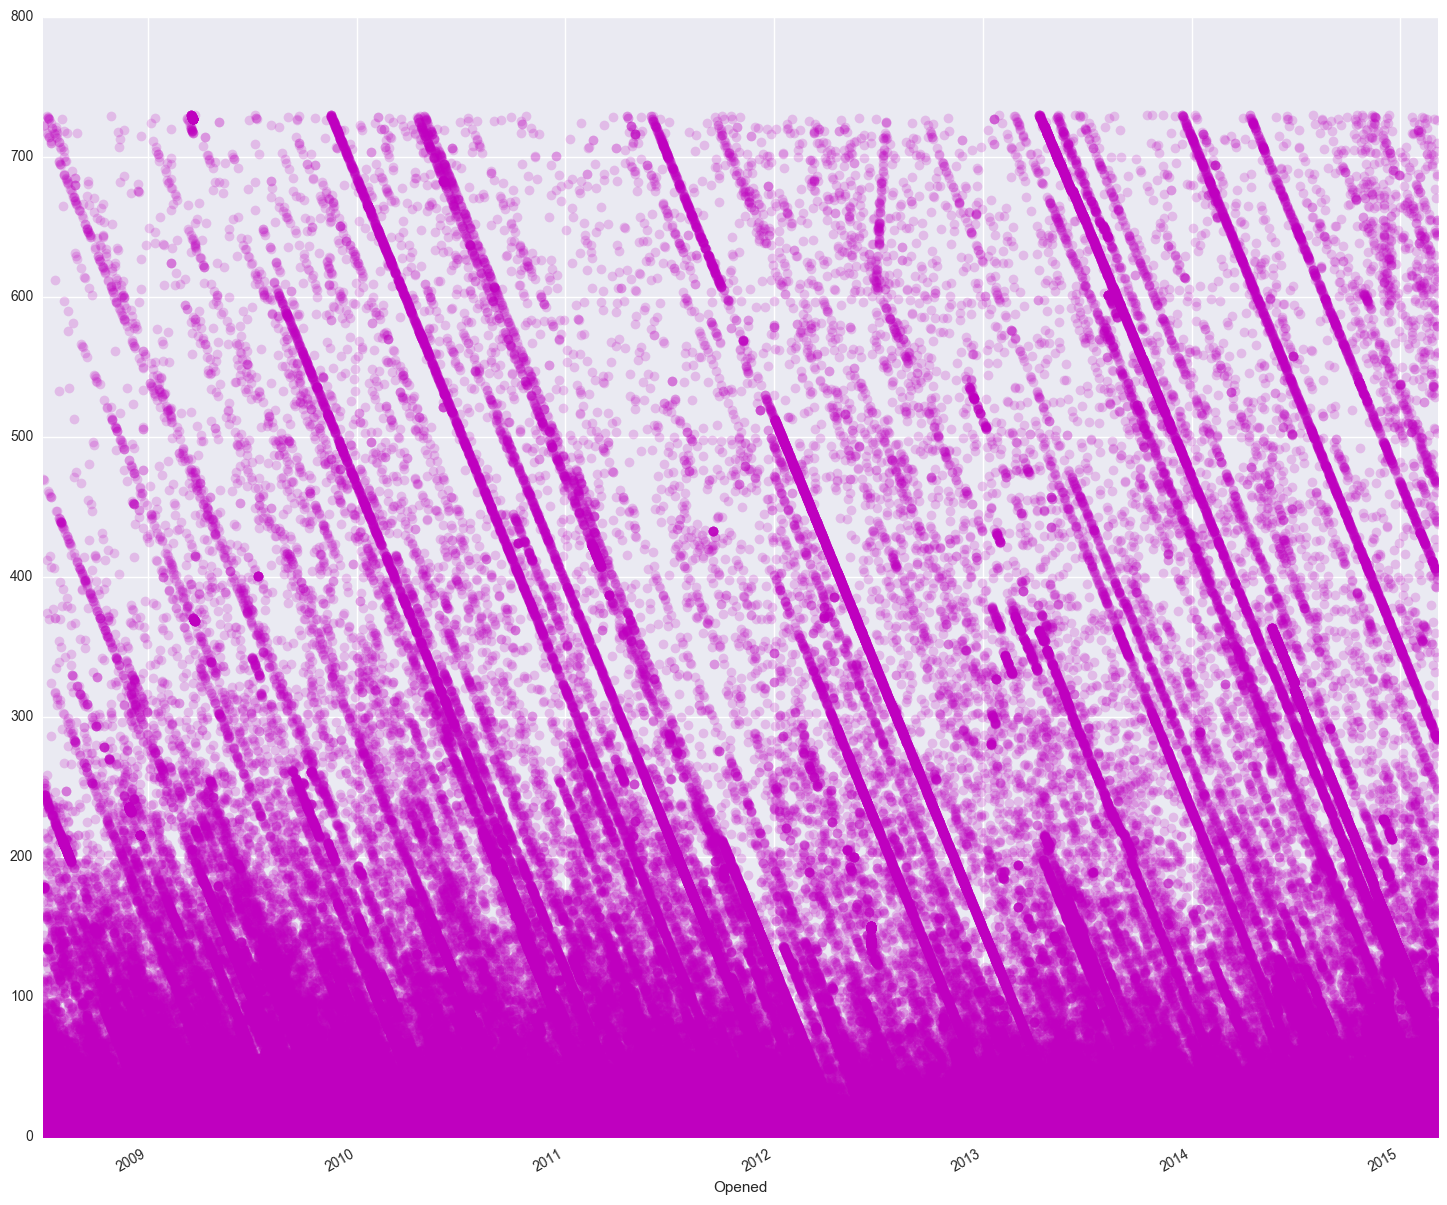

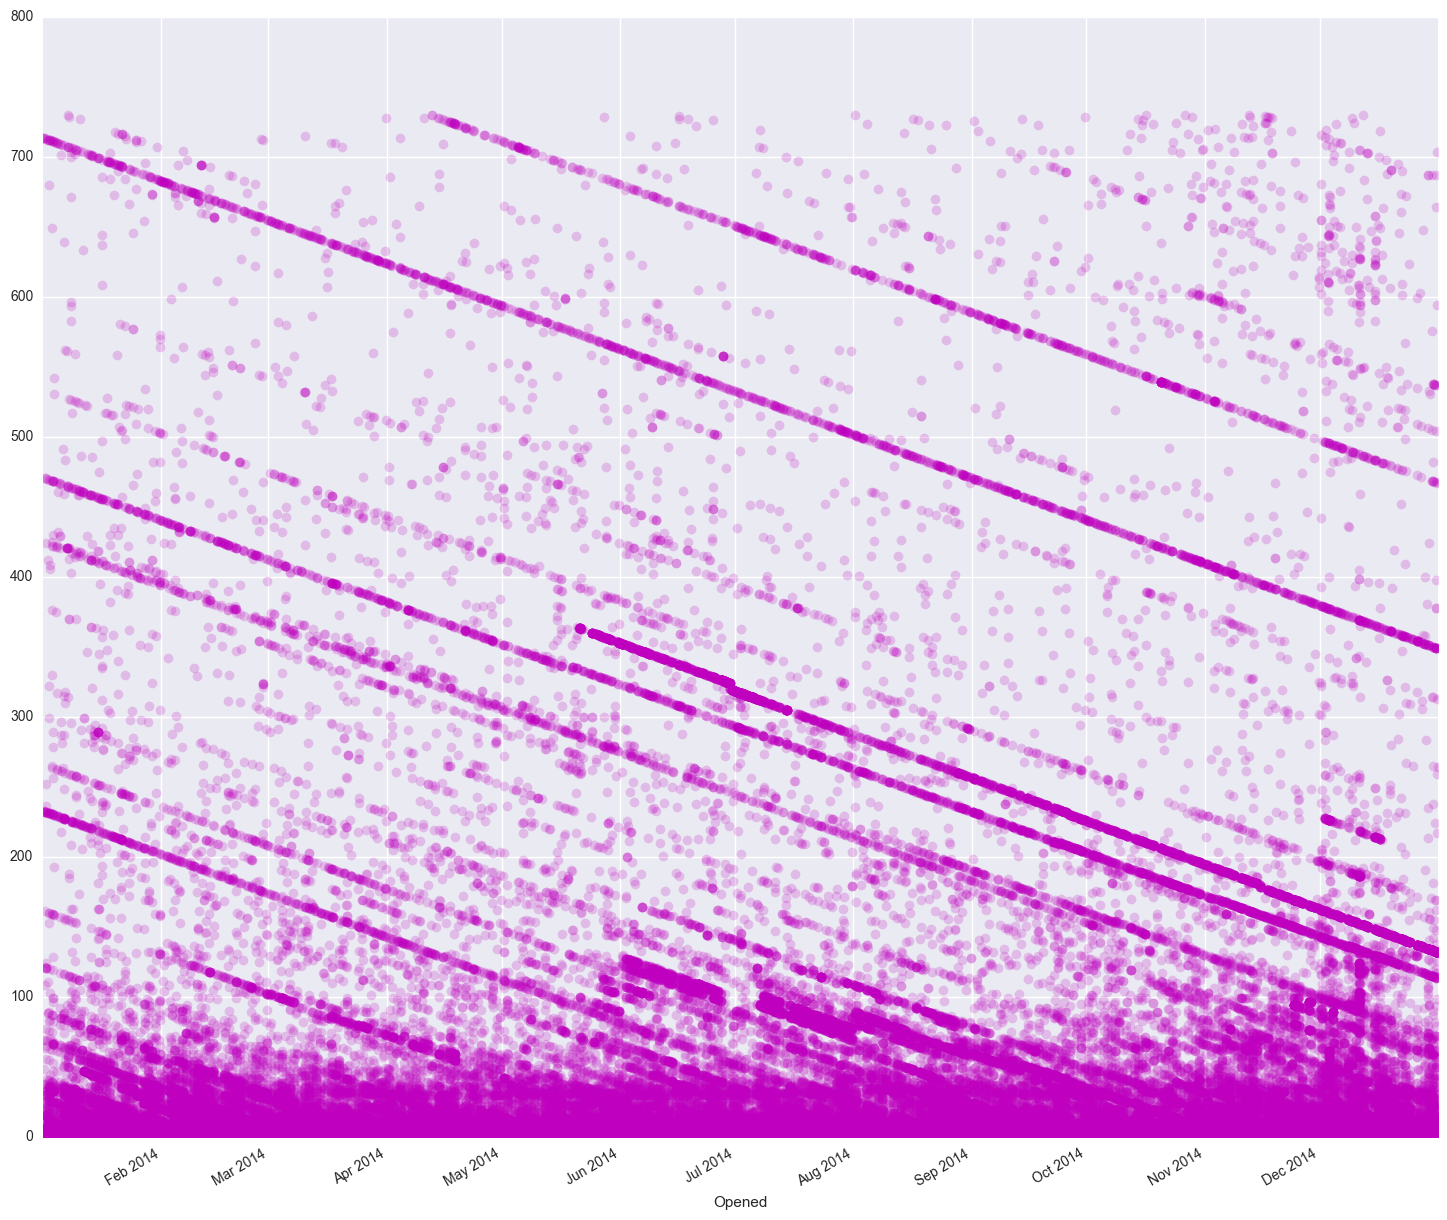

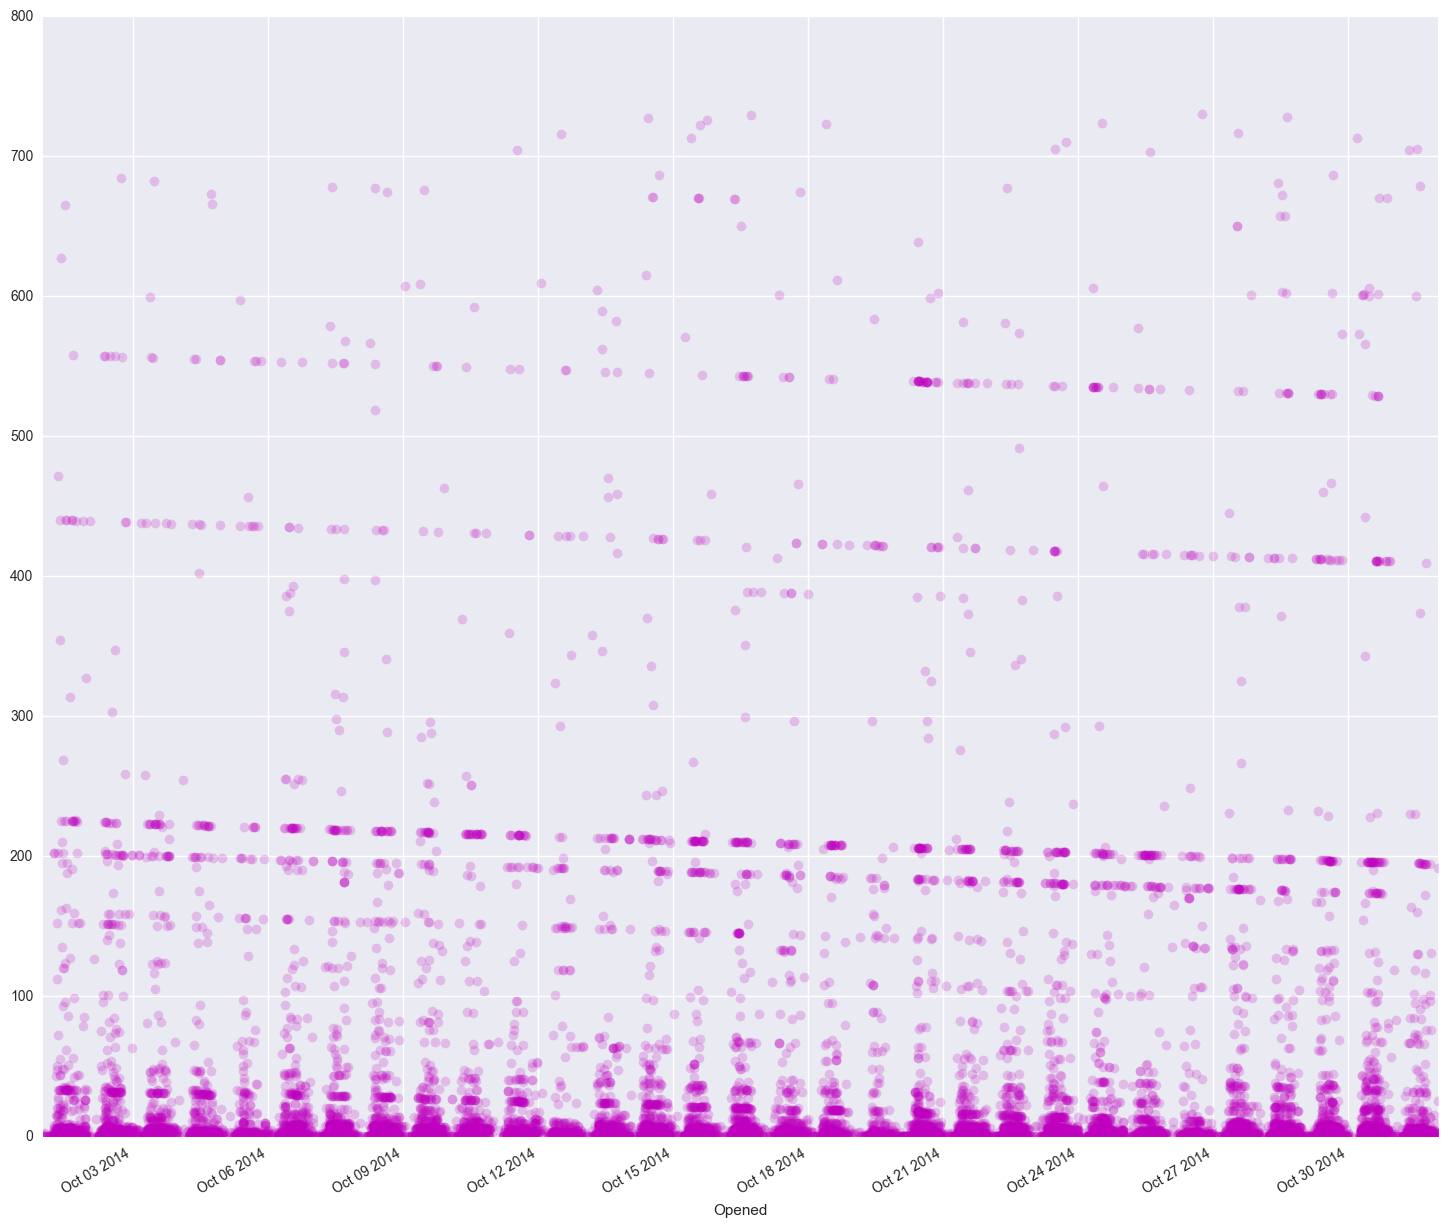

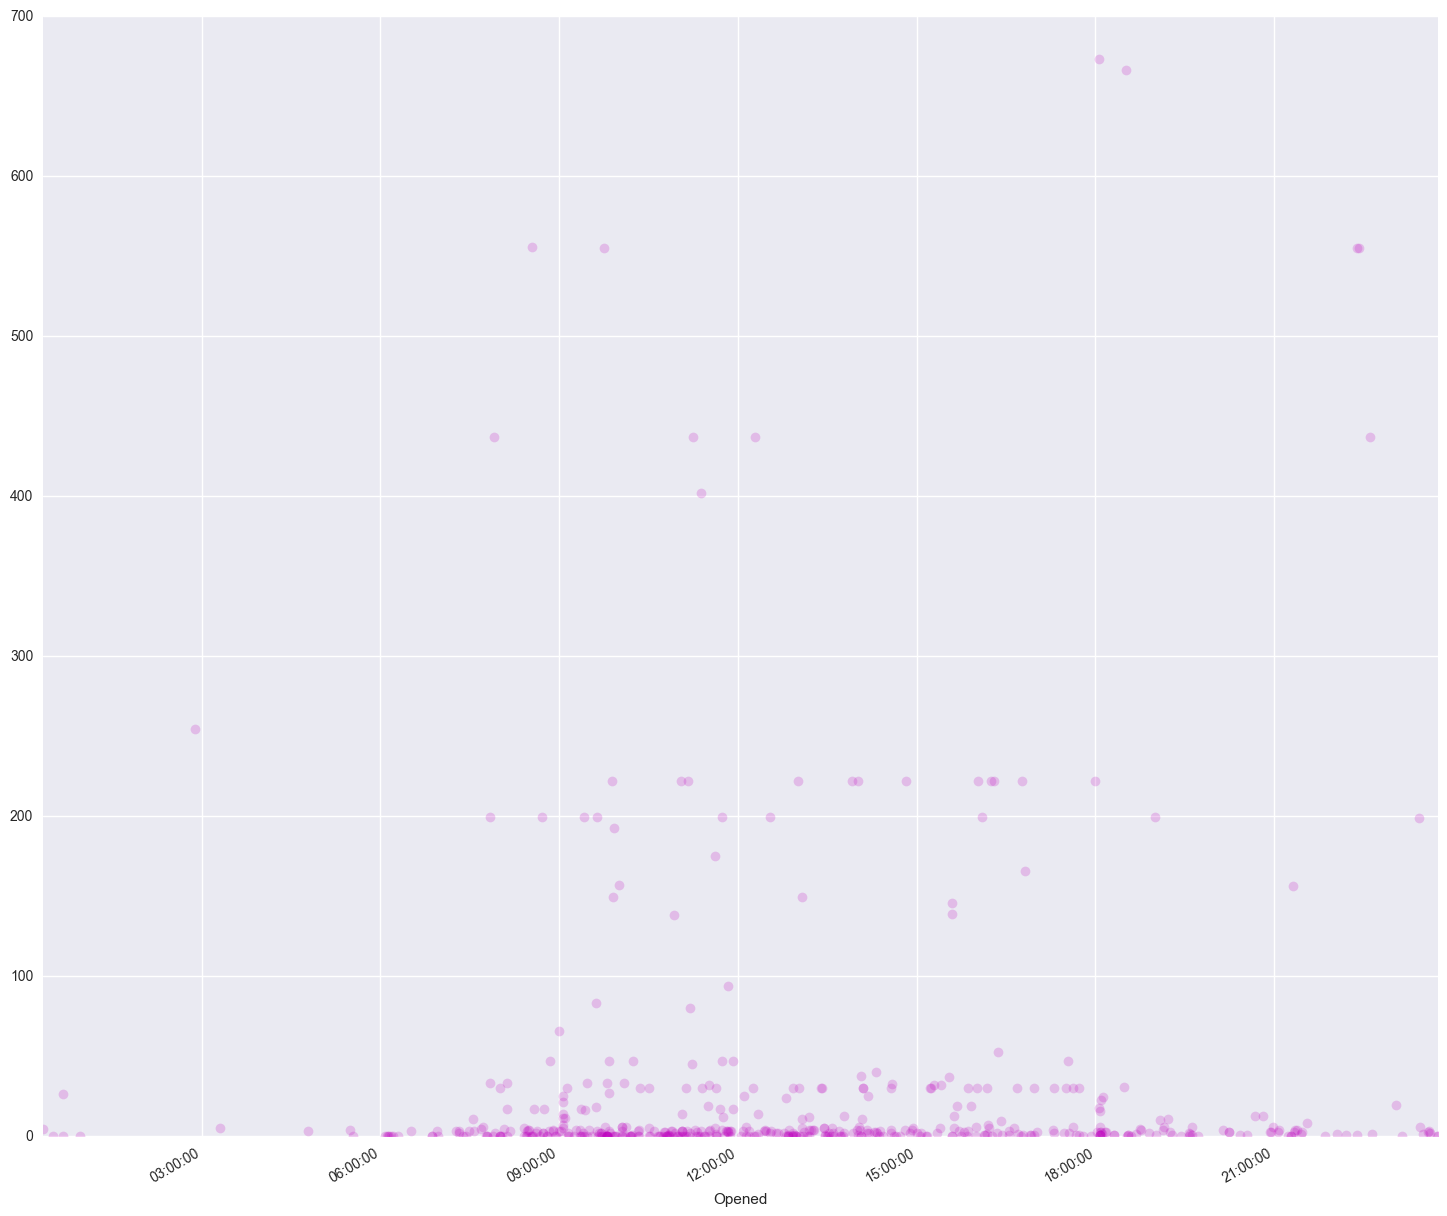

In [53]:
'''plot process days over the time'''
plot_data_on_date(df_chunk, 'Process_days')
plot_data_on_date(df_chunk, 'Process_days', year = 2014)
plot_data_on_date(df_chunk, 'Process_days', year = 2014, month = 10)
plot_data_on_date(df_chunk, 'Process_days', year = 2014, month = 10, day = 4)

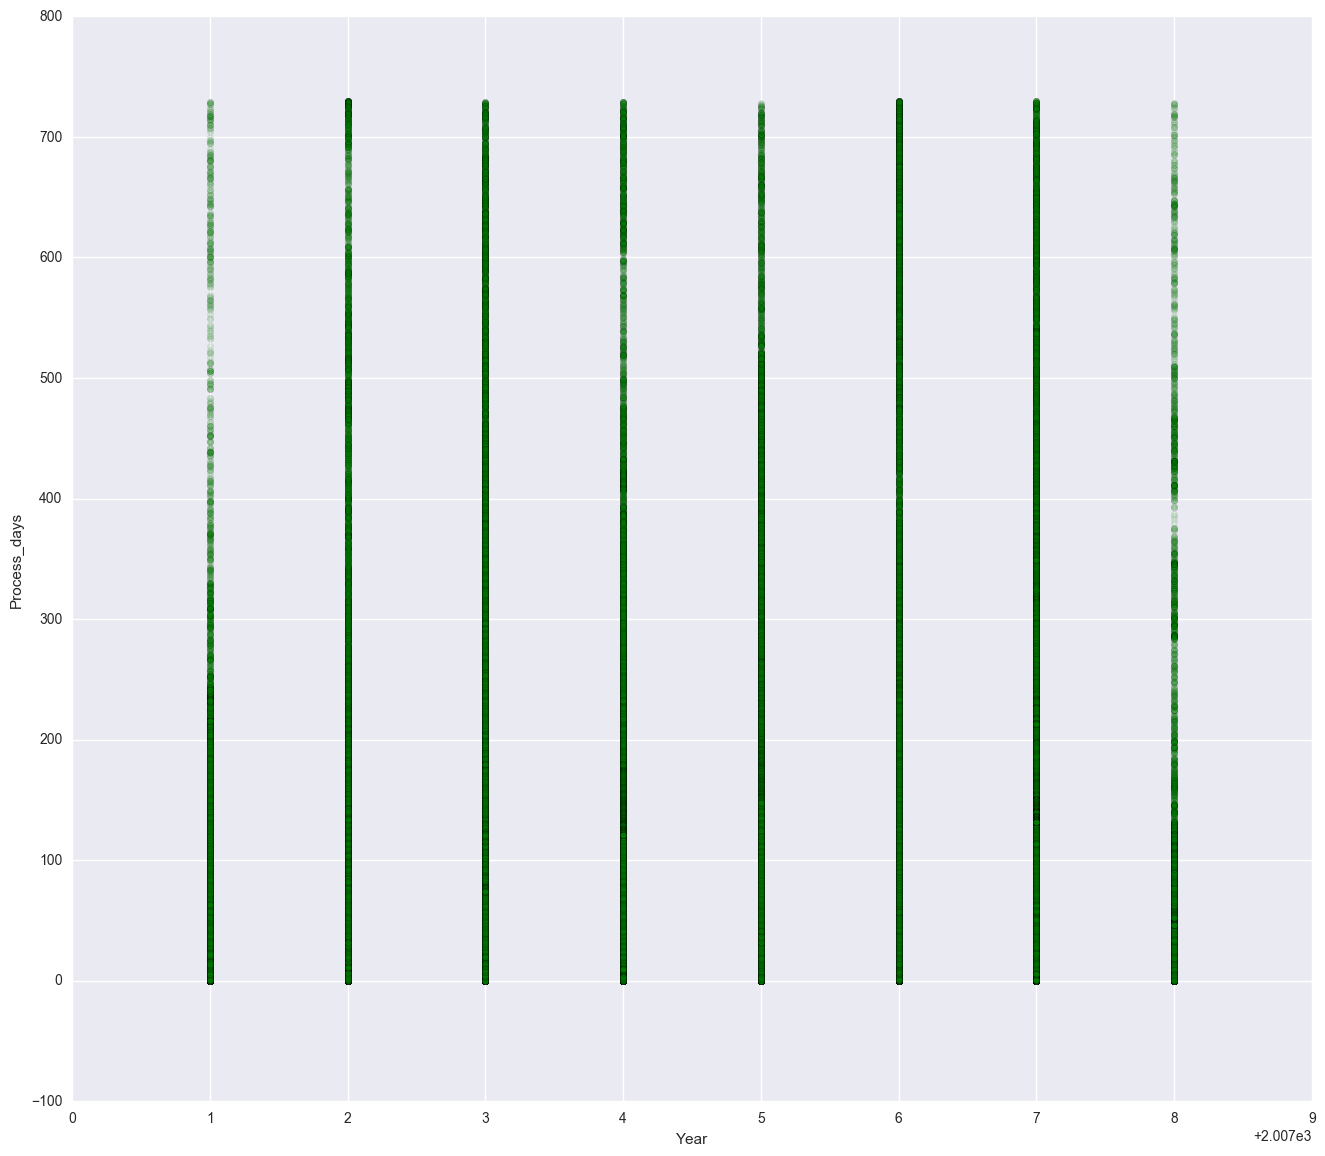

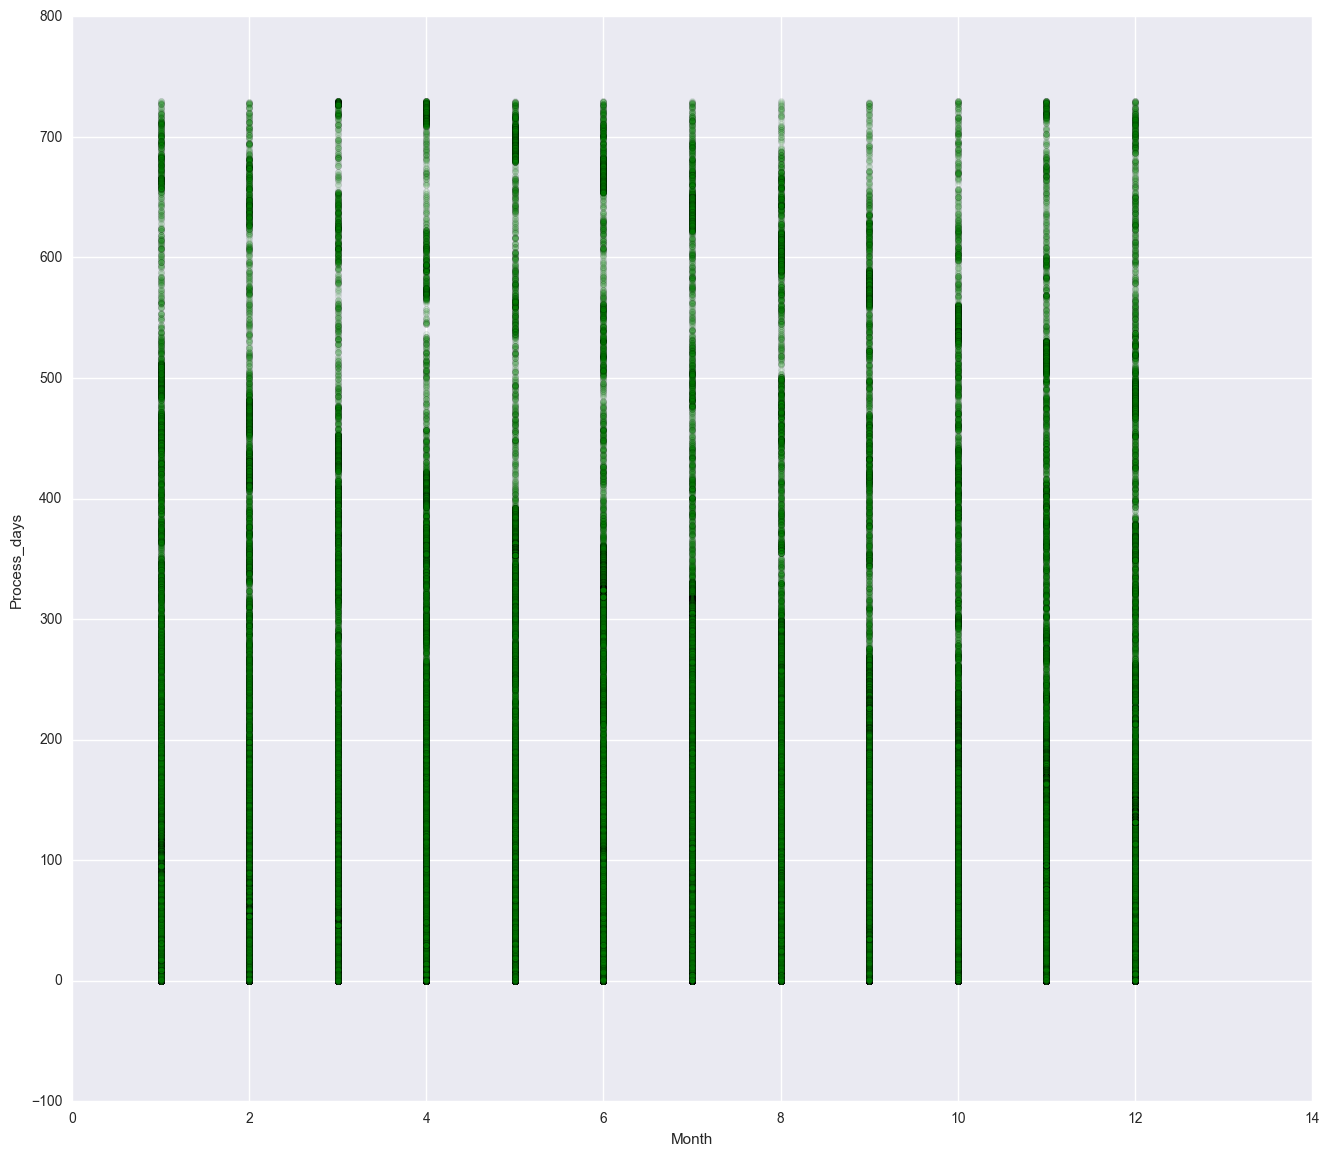

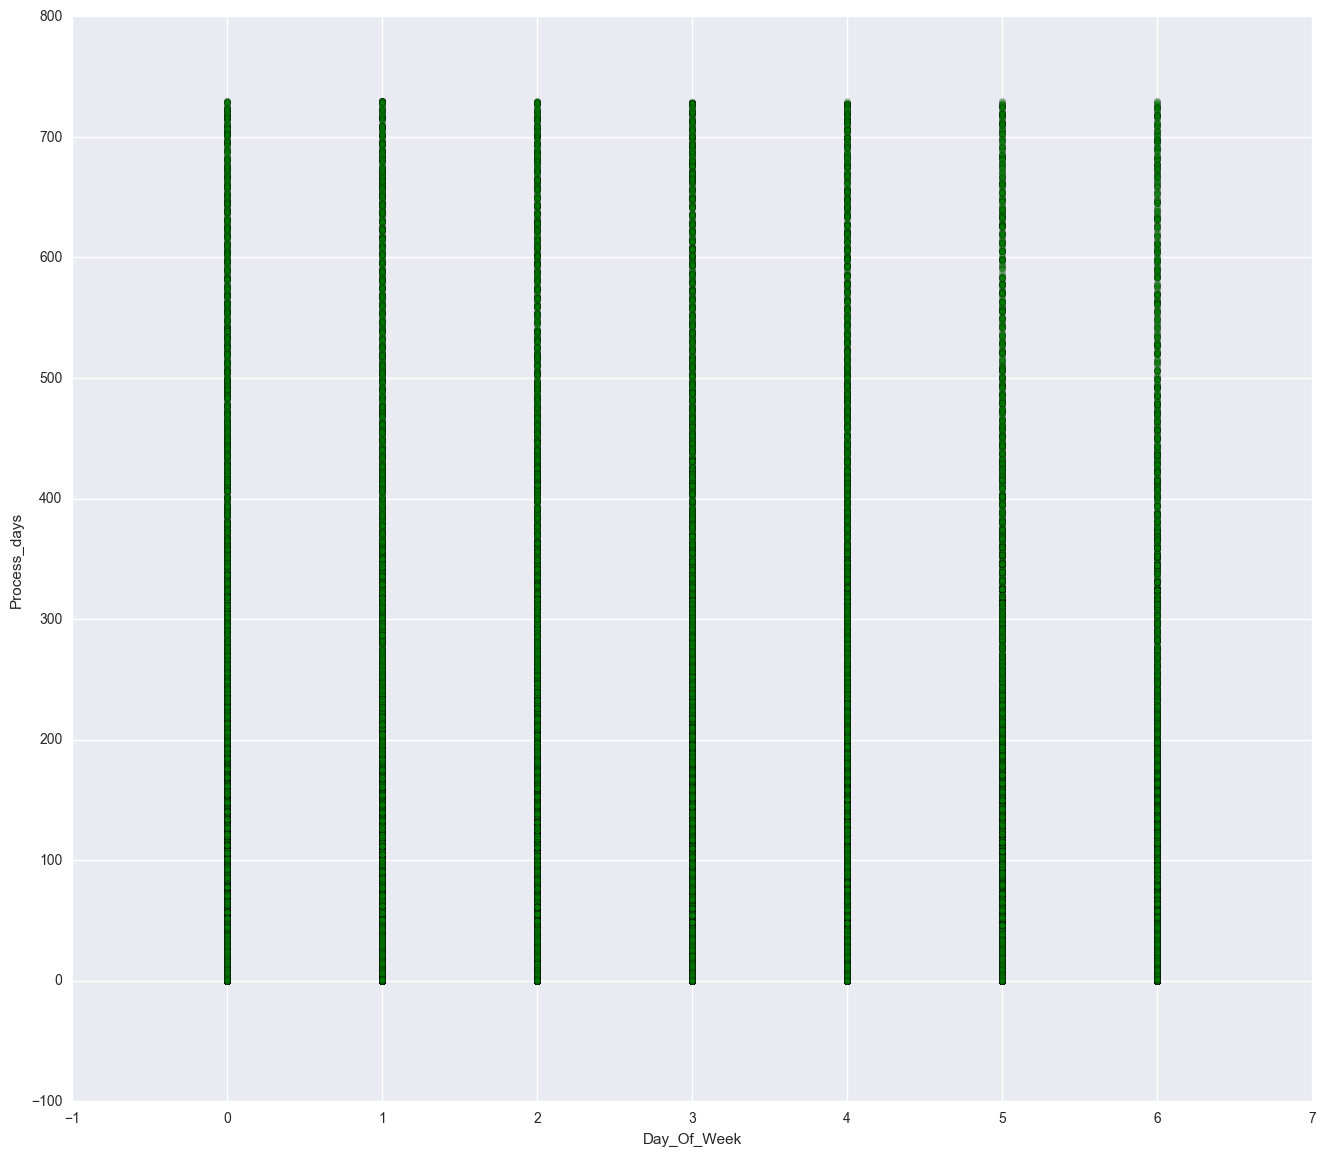

In [64]:
df_chunk.plot(kind = 'scatter', x='Year', y='Process_days', c = 'g', alpha = 0.1, figsize = (16,14))
plt.show()
df_chunk.plot(kind = 'scatter', x='Month', y='Process_days',c = 'g', alpha = 0.1,figsize = (16,14))
plt.show()
df_chunk.plot(kind = 'scatter', x='Day_Of_Week', y='Process_days',c = 'g', alpha = 0.1,figsize = (16,14))
plt.show()

In [76]:
'''check the mean of Process_days group by different features'''
groupby_list = ['Day_Of_Week','Month','Year','Weekend','Holiday','Before_Holiday']
targets = ['Process_days']
check_group_mean(df_chunk,groupby_list,targets )
check_group_stats(df_chunk,groupby_list,targets )

             Process_days
Day_Of_Week              
0               27.466929
1               27.995211
2               28.634151
3               30.009399
4               30.341706
5               31.086068
6               29.319826
       Process_days
Month              
1         25.410472
2         26.518161
3         26.518435
4         29.807834
5         34.452890
6         36.651014
7         31.117966
8         29.396942
9         27.159757
10        27.325187
11        29.074075
12        28.605651
      Process_days
Year              
2008     26.577516
2009     31.209805
2010     38.660945
2011     28.948570
2012     30.198487
2013     26.764028
2014     26.522396
2015     20.260133
         Process_days
Weekend              
0           28.821594
1           30.250746
         Process_days
Holiday              
0           29.103146
1           29.286126
                Process_days
Before_Holiday              
0                  29.096861
1                  29.565568
    

In [92]:
year_list = [2008,2009,2010,2011]
p = get_oneway_anova(df_chunk, 'Process_days', 'Year', year_list)

One-way ANOVA P = 8.97034312066e-298


In [65]:
'''Read data from still open cases'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_open = 'SF311_still_open_raw.csv'
df_open = get_prep_data(folder+filename_open)

print 'Still open cases info: ', df_open.info()
df_open.tail()

Still open cases info: <class 'pandas.core.frame.DataFrame'>
Int64Index: 99549 entries, 240370 to 6909918
Data columns (total 15 columns):
Opened                 99549 non-null datetime64[ns]
Closed                 0 non-null datetime64[ns]
Updated                99549 non-null object
Status                 99549 non-null object
Status Notes           86265 non-null object
Responsible Agency     99549 non-null object
Category               99549 non-null object
Request Type           99302 non-null object
Request Details        95562 non-null object
Address                99508 non-null object
Supervisor District    97889 non-null float64
Neighborhood           91479 non-null object
Point                  93965 non-null object
Source                 99511 non-null object
Media URL              21055 non-null object
dtypes: datetime64[ns](2), float64(1), object(12)
memory usage: 12.2+ MB
 None


Opened Closed              Updated Status Status Notes  \
CaseID                                                                        
6909907 2017-03-07 00:27:23    NaT  2017-03-07 00:27:23   Open         open   
6909908 2017-03-07 00:30:02    NaT  2017-03-07 00:30:02   Open         Open   
6909911 2017-03-07 00:31:53    NaT  2017-03-07 00:31:53   Open         open   
6909913 2017-03-07 00:37:52    NaT  2017-03-07 00:37:52   Open         Open   
6909918 2017-03-07 00:49:31    NaT  2017-03-07 00:49:31   Open         Open   

                    Responsible Agency          Category  \
CaseID                                                     
6909907         PUC Streetlights Queue      Streetlights   
6909908                  RPD NSA Queue      Streetlights   
6909911         PUC Streetlights Queue      Streetlights   
6909913  Clear Channel - Transit Queue  Damaged Property   
6909918             Noise Report Queue      Noise Report   

                             Request Type  \
CaseID                                      
6909907     Streetlight - Light_Burnt_Out   
6909908     Streetlight - Light_Burnt_Out   
6909911     Streetlight - Light_Burnt_Out   
6909913  Damaged Transit_Shelter_Platform   
6909918             other_excessive_noise   

                              Request Details  \
CaseID                                          
6909907         Light_Burnt_Out on Metal Pole   
6909908         Light_Burnt_Out on Metal Pole   
6909911         Light_Burnt_Out on Metal Pole   
6909913              Transit_Shelter_Platform   
6909918  Noise Report - other_excessive_noise   

                                               Address  Supervisor District  \
CaseID                                                                        
6909907       Intersection of GREAT HWY and SLOAT BLVD                  4.0   
6909908  GGP Rainbow Falls, , SAN FRANCISCO, CA, 94122                  1.0   
6909911       Intersection of 19TH AVE and SANTIAGO ST                  7.0   
6909913        Intersection of GEARY BLVD and 33RD AVE                  1.0   
6909918         Not associated with a specific address                  NaN   

             Neighborhood                                  Point  \
CaseID                                                             
6909907          Parkside  (37.7355712092976, -122.506135173684)   
6909908  Golden Gate Park           (37.771021944, -122.4788088)   
6909911               NaN  (37.7449187870055, -122.475773144722)   
6909913    Outer Richmond  (37.7796884192014, -122.493297188897)   
6909918               NaN                                    NaN   

                   Source Media URL  
CaseID                               
6909907  Web Self Service       NaN  
6909908  Web Self Service       NaN  
6909911  Web Self Service       NaN  
6909913  Web Self Service       NaN  
6909918  Web Self Service       NaN

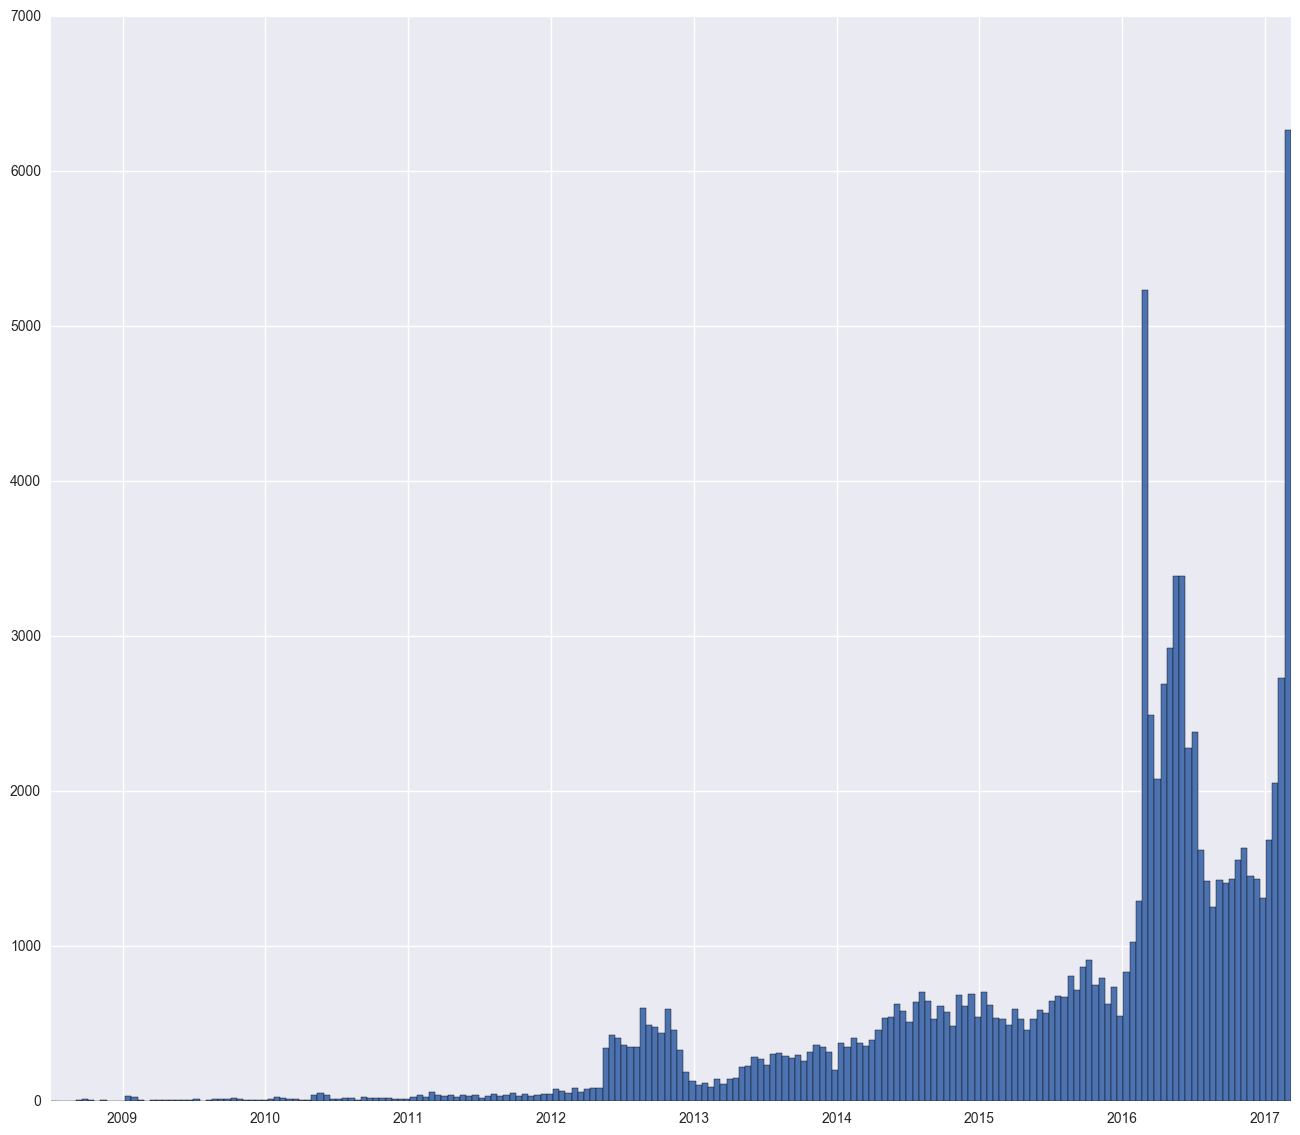

In [68]:
df_open['Opened'].hist(bins = 200, figsize = (16,14))

In [51]:
'''Create a pilot dataset of most recent 100000 cases for preliminary modeling 
and feature engineering, save as SF311_pilot.csv '''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/data/'
filename_pilot = 'SF311_pilot.csv'
create_pilot(df, folder, filename_pilot)

'''Read data from new pilot csv file'''
pdf = get_prep_data(folder+filename_pilot)

print 'Pilot dataframe info: ', pdf.info()
pdf.head(2)

Pilot dataframe info: <class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 185580 to 407691
Data columns (total 19 columns):
Opened                 100000 non-null datetime64[ns]
Closed                 100000 non-null datetime64[ns]
Status Notes           167 non-null object
Responsible Agency     100000 non-null object
Category               100000 non-null object
Request Type           100000 non-null object
Request Details        98013 non-null object
Address                100000 non-null object
Supervisor District    100000 non-null float64
Neighborhood           99950 non-null object
Point                  99999 non-null object
Source                 100000 non-null object
Process_days           100000 non-null float64
Process_hours          100000 non-null float64
Day_Of_Week            100000 non-null int64
Month                  100000 non-null int64
Weekend                100000 non-null int64
Holiday                100000 non-null int64
Before_Holiday         10

Opened              Closed  \
CaseID                                           
185580 2008-03-20 11:48:32 2013-03-26 18:13:25   
196699 2008-04-13 14:04:28 2015-06-11 12:00:00   

                                             Status Notes Responsible Agency  \
CaseID                                                                         
185580                         Case Completed - resolved:      DPW Ops Queue   
196699  Case Completed - resolved:  Request closed by ...      DPW Ops Queue   

                Category               Request Type  \
CaseID                                                
185580  Tree Maintenance  Trees - Damaging_Property   
196699  Tree Maintenance  Trees - Damaging_Property   

                   Request Details  \
CaseID                               
185580  Lifted_sidewalk_tree_roots   
196699  Lifted_sidewalk_tree_roots   

                                           Address  Supervisor District  \
CaseID                                                                    
185580     Intersection of FILLMORE ST and TURK ST                  5.0   
196699  479 GOLD MINE DR, SAN FRANCISCO, CA, 94131                  8.0   

            Neighborhood                                  Point    Source  \
CaseID                                                                      
185580  Western Addition  (37.7804961587438, -122.432140368666)  Voice In   
196699   Diamond Heights   (37.739925905095, -122.436581251375)  Voice In   

        Process_days  Process_hours  Day_Of_Week  Month  Weekend  Holiday  \
CaseID                                                                      
185580   1832.266667        43974.4            3      3        0        0   
196699   2614.912500        62757.9            6      4        1        0   

        Before_Holiday  
CaseID                  
185580               0  
196699               0

In [ ]:
'''covert categorical features to numerical'''
cate_list = ['Category','Responsible Agency','Request Type','Neighborhood','Source']
cate_dict = batch_process_categories(df, cate_list)
df.head()
cate_dict['Category'][23]

In [ ]:
'''add column Current_Open which has the number of current open cases'''
#dft_valid = add_current_open(dft_valid)
#dft_valid.iloc[100:125,:]

In [ ]:
dfm = df.groupby('Category')['Process_hours'].describe()
print cate_dict['Category'].items()
dfm

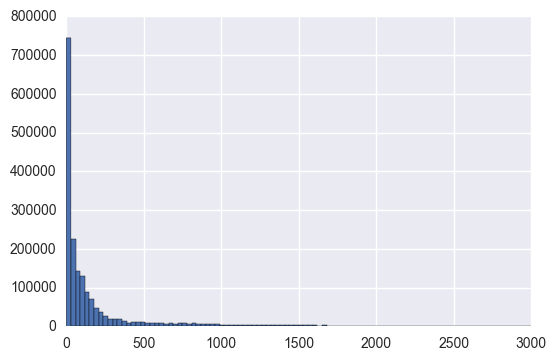

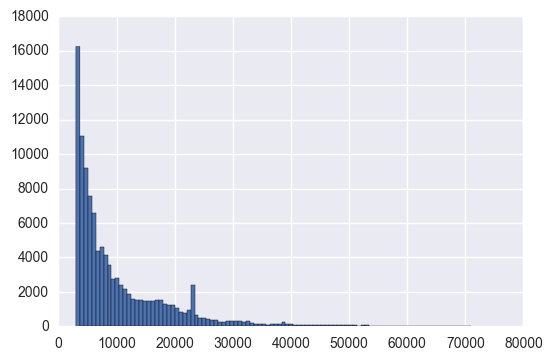

1860501
109292


In [13]:
'''plot the histogram of Category and Request type'''
# cfdf.Process_hours.hist(bins =100)
# plt.show()
'''Distribution of process time is very skewed'''

cfdf_norm = cfdf[cfdf.Process_hours < 3000]
cfdf_extreme = cfdf[cfdf.Process_hours >= 3000]
cfdf_norm.Process_hours.hist(bins =100)
plt.show()
cfdf_extreme.Process_hours.hist(bins =100)
plt.show()

print len(cfdf_norm)
print len(cfdf_extreme)

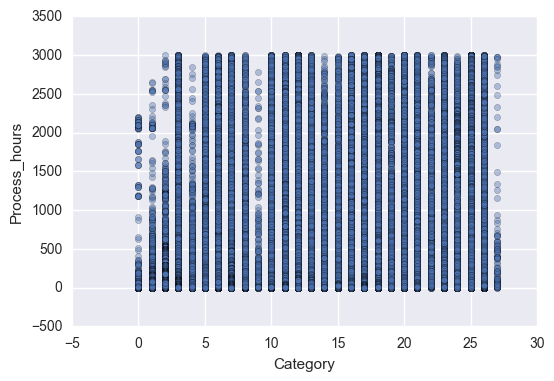

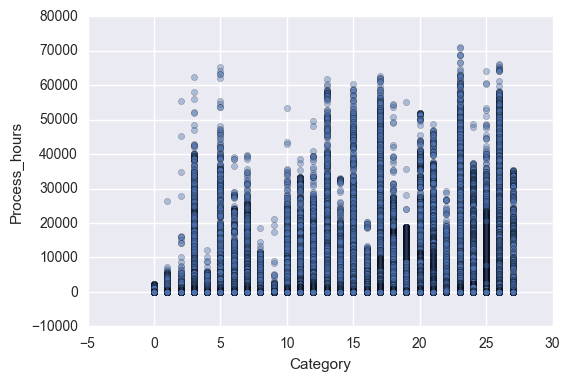

In [16]:
cfdf_norm.plot(kind = 'scatter', x='Category', y='Process_hours', alpha = 0.4)
plt.show()
cfdf.plot(kind = 'scatter', x='Category', y='Process_hours', alpha = 0.4)
plt.show()

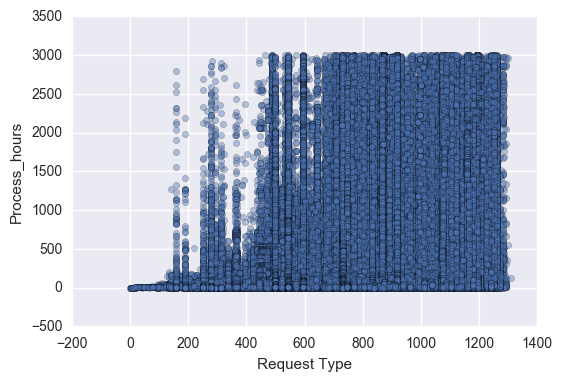

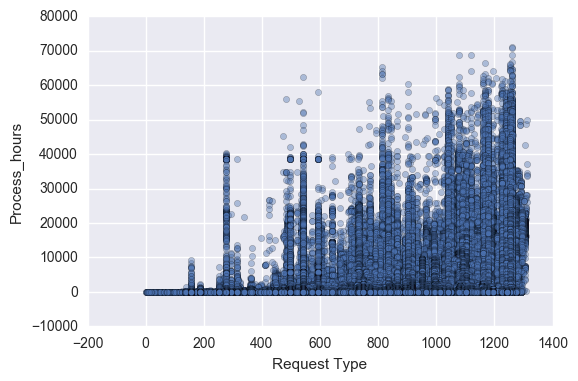

In [31]:
cfdf_norm.plot(kind = 'scatter', x='Request Type', y='Process_hours', alpha = 0.4)
plt.show()
cfdf.plot(kind = 'scatter', x='Request Type', y='Process_hours', alpha = 0.4)
plt.show()

CaseID   2092917
Opened   2029272
Closed   1485294
Updated   1570351
Status   2
Status Notes   348637
Responsible Agency   409
Category   28
Request Type   1419
Request Details   133593
Address   199413
Supervisor District   14
Neighborhood   126
Point   217287
Source   9
Media URL   377721

In [ ]:
cfdf1 = get_prep_data(dft_valid_fewer_features_csv_path)

In [45]:
df_sh = cfdf1[cfdf1['Process_hours'] < 0.5].sort_values('Process_hours')
print len(df_sh)
print len(cfdf1)
df_sh.head(20)

34276
1969793


Opened  \
CaseID                        
2335621 2013-05-07 09:56:27   
5420600 2015-12-31 14:54:22   
4398367 2015-01-16 07:05:02   
4398310 2015-01-16 05:57:05   
4398291 2015-01-16 05:30:07   
6136978 2016-07-30 00:17:23   
4398285 2015-01-16 05:13:00   
4397319 2015-01-15 16:18:07   
2822972 2013-09-13 08:32:21   
2826229 2013-09-13 18:50:08   
6136292 2016-07-29 17:02:31   
2828101 2013-09-14 14:18:29   
4397282 2015-01-15 16:09:36   
6136067 2016-07-29 16:09:18   
6136013 2016-07-29 16:01:14   
6135933 2016-07-29 15:51:48   
2829810 2013-09-15 10:20:16   
6136882 2016-07-29 22:34:14   
2822544 2013-09-13 06:32:15   
4398689 2015-01-16 09:02:17   

                                              Status Notes  \
CaseID                                                       
2335621                     Case Resolved - Meter repaired   
5420600  Case Resolved - COMPLAINT WAS GIVEN TO OFFICER...   
4398367                                 Case Transferred -   
4398310                              Case is a Duplicate -   
4398291                              Case is a Duplicate -   
6136978                              Case is a Duplicate -   
4398285                Case Resolved - GATEMAN DISPATCHED.   
4397319  Case Transferred - CASE TRANSFERRED TO SFWD PA...   
2822972     Case Resolved - 9/13/2013 - INSTALLED 15W LAMP   
2826229  Case Resolved - Duplicate, see original SR sti...   
6136292                         Scheduled - Case Scheduled   
2828101  Case is a Duplicate - 311 CALLED THIS INCIDENT...   
4397282  Case Completed - resolved: DUPLICATE SERVICE R...   
6136067                         Scheduled - Case scheduled   
6136013                         Scheduled - Case scheduled   
6135933                    Case Resolved - driver en route   
2829810                  Case is a Duplicate - DUP/2829321   
6136882  Case is Invalid - This type of noise complaint...   
2822544  Case is a Duplicate - Broken stopcock. Schedul...   
4398689  Case Completed - resolved: DUPLICATE SERVICE R...   

                      Responsible Agency                      Category  \
CaseID                                                                   
2335621             DPT Meter_Bike Queue              Damaged Property   
5420600  SFMTA - Parking Enforcement - G              General Requests   
4398367                  PUC - Water - G                  Sewer Issues   
4398310                  PUC - Water - G                  Sewer Issues   
4398291                  PUC - Water - G                  Sewer Issues   
6136978                    DPW Ops Queue     Graffiti Private Property   
4398285                  PUC - Water - G                  Sewer Issues   
4397319                  PUC - Water - G              General Requests   
2822972           PUC Streetlights Queue                  Streetlights   
2826229        311 Service Request Queue          311 External Request   
6136292                  PUC - Water - G      Graffiti Public Property   
2828101                  PUC - Water - G                  Sewer Issues   
4397282               Recology_Abandoned  Street and Sidewalk Cleaning   
6136067                  PUC - Water - G      Graffiti Public Property   
6136013                  PUC - Water - G      Graffiti Public Property   
6135933             Recology_Overflowing  Street and Sidewalk Cleaning   
2829810                  PUC - Water - G                  Sewer Issues   
6136882             311 Supervisor Queue                  Noise Report   
2822544                  PUC - Water - G                  Sewer Issues   
4398689               Recology_Abandoned  Street and Sidewalk Cleaning   

                                            Request Type  \
CaseID                                                     
2335621                            Damaged Parking_Meter   
5420600  mta - parking_enforcement - request_for_service   
4398367                                       Water_leak   
4398310                                     

In [61]:
# get_str_list = lambda x: str(x).split()
# check_dup = lambda x: 'Duplicate' in x

# cfdf1['Status_notes'] = cfdf1['Status Notes'].apply(get_str_list) # turn cfdf1['Status_notes'] into a list of strings
# cond = cfdf1['Status_notes'].apply(check_dup) # check if cfdf1['Status_notes'] contains the word 'Duplicate'
# df_dup = cfdf1[cond]

# con = cfdf1['Duplicate' in cfdf1['Status_notes']]
# cfdf1.head()
# con
# df_dup = cfdf1['Duplicate' in cfdf1['Status Notes'].apply(get_str_list)]
# len(df_dup)
df_dup = check_word_in_col(cfdf1, 'Status Notes', 'Duplicate')
print len(df_dup)
df_dup.head(20)

'''There are 34773 duplicated cases, remove these cases'''

34773


'There are 34773 duplicated cases, remove these cases'